# Trabajo Práctico: Exploración y Preparación de Airbnb Listings


## Objetivo
En esta libreta analizamos el dataset `listings_big.csv` para comprender su estructura, diagnosticar problemas de calidad y preparar un conjunto de features apto para estimar **qué tan alquilable es un listing**. El flujo general incluye:
- Exploración inicial y resumen estadístico
- Análisis de valores faltantes y patrones de disponibilidad
- Visualizaciones que permitan interpretar la ocupación y sus drivers
- Definición de un problema supervisado de clasificación enfocado en la alta ocupación
- Construcción de un pipeline de preprocesamiento, ingeniería de variables y selección/reducción de dimensionalidad


# 🏡 Airbnb Listings Data Dictionary

> Diccionario de datos del conjunto de listados de Airbnb, con tipos de datos, campos calculados y descripciones.  
> Compatible con visualización en GitHub (scroll horizontal automático en tablas grandes).

---

<div style="overflow-x: auto;">

| **Field** | **Type** | **Calculated** | **Description** |
|------------|-----------|----------------|-----------------|
| id | integer |  | Airbnb's unique identifier for the listing |
| listing_url | text | ✅ |  |
| scrape_id | bigint | ✅ | Inside Airbnb "Scrape" this was part of |
| last_scraped | datetime | ✅ | UTC. The date and time this listing was "scraped". |
| source | text |  | One of `"neighbourhood search"` or `"previous scrape"`. Describes how the listing was discovered. |
| name | text |  | Name of the listing |
| description | text |  | Detailed description of the listing |
| neighborhood_overview | text |  | Host's description of the neighbourhood |
| picture_url | text |  | URL to Airbnb-hosted regular-sized image |
| host_id | integer |  | Airbnb's unique identifier for the host/user |
| host_url | text | ✅ | Airbnb page for the host |
| host_name | text |  | Name of the host (usually first name). |
| host_since | date |  | Host account creation date |
| host_location | text |  | Host's self-reported location |
| host_about | text |  | Description about the host |
| host_response_time | text |  |  |
| host_response_rate | text |  |  |
| host_acceptance_rate | text |  | Rate at which host accepts booking requests |
| host_is_superhost | boolean *(t=true; f=false)* |  |  |
| host_thumbnail_url | text |  |  |
| host_picture_url | text |  |  |
| host_neighbourhood | text |  |  |
| host_listings_count | text |  | Number of listings (Airbnb internal) |
| host_total_listings_count | text |  | Total listings (Airbnb internal) |
| host_verifications | text |  |  |
| host_has_profile_pic | boolean *(t=true; f=false)* |  |  |
| host_identity_verified | boolean *(t=true; f=false)* |  |  |
| neighbourhood | text |  |  |
| neighbourhood_cleansed | text | ✅ | Geocoded neighbourhood (from shapefiles) |
| neighbourhood_group_cleansed | text | ✅ | Geocoded neighbourhood group (from shapefiles) |
| latitude | numeric |  | WGS84 latitude |
| longitude | numeric |  | WGS84 longitude |
| property_type | text |  | Self-selected property type |
| room_type | text |  | One of:<br>• **Entire home/apt** — Whole space<br>• **Private room** — Own room, shared areas<br>• **Shared room** — Shared sleeping space |
| accommodates | integer |  | Max guest capacity |
| bathrooms | numeric |  | Number of bathrooms |
| bathrooms_text | string |  | Text description of bathrooms (legacy field) |
| bedrooms | integer |  | Number of bedrooms |
| beds | integer |  | Number of beds |
| amenities | json |  | JSON array of amenities |
| price | currency |  | Daily price (ignore `$` artifact) |
| minimum_nights | integer |  | Minimum nights allowed |
| maximum_nights | integer |  | Maximum nights allowed |
| minimum_minimum_nights | integer | ✅ | Smallest min nights (calendar, 365 days ahead) |
| maximum_minimum_nights | integer | ✅ | Largest min nights (calendar, 365 days ahead) |
| minimum_maximum_nights | integer | ✅ | Smallest max nights (calendar, 365 days ahead) |
| maximum_maximum_nights | integer | ✅ | Largest max nights (calendar, 365 days ahead) |
| minimum_nights_avg_ntm | numeric | ✅ | Avg min nights (calendar, 365 days ahead) |
| maximum_nights_avg_ntm | numeric | ✅ | Avg max nights (calendar, 365 days ahead) |
| calendar_updated | date |  |  |
| has_availability | boolean |  | *(t=true; f=false)* |
| availability_30 | integer | ✅ | Available nights (next 30 days) |
| availability_60 | integer | ✅ | Available nights (next 60 days) |
| availability_90 | integer | ✅ | Available nights (next 90 days) |
| availability_365 | integer | ✅ | Available nights (next 365 days) |
| calendar_last_scraped | date |  |  |
| number_of_reviews | integer |  | Total number of reviews |
| number_of_reviews_ltm | integer | ✅ | Reviews in last 12 months |
| number_of_reviews_l30d | integer | ✅ | Reviews in last 30 days |
| first_review | date | ✅ | Date of first review |
| last_review | date | ✅ | Date of most recent review |
| review_scores_rating | numeric |  |  |
| review_scores_accuracy | numeric |  |  |
| review_scores_cleanliness | numeric |  |  |
| review_scores_checkin | numeric |  |  |
| review_scores_communication | numeric |  |  |
| review_scores_location | numeric |  |  |
| review_scores_value | numeric |  |  |
| license | text |  | Licence/permit/registration number |
| instant_bookable | boolean |  | *(t=true; f=false)* — Guests can book instantly |
| calculated_host_listings_count | integer | ✅ | Number of listings host has in this scrape (city/region) |
| calculated_host_listings_count_entire_homes | integer | ✅ | Entire homes owned by host |
| calculated_host_listings_count_private_rooms | integer | ✅ | Private rooms owned by host |
| calculated_host_listings_count_shared_rooms | integer | ✅ | Shared rooms owned by host |
| reviews_per_month | numeric | ✅ | Average reviews per month over listing lifetime.<br><br>**Pseudocode/SQL:**<br>`IF scrape_date - first_review <= 30 THEN number_of_reviews`<br>`ELSE number_of_reviews / ((scrape_date - first_review + 1) / (365/12))` |

</div>

---

✅ = Calculated field  
📘 *Boolean values*: `t=true`, `f=false`  
🌐 *Coordinates*: WGS84 projection  
💡 *Source*: [Inside Airbnb](https://insideairbnb.com/)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import missingno as msno

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 5)
pd.set_option('display.max_columns', 80)
pd.set_option("display.float_format", "{:.4f}".format)

DATA_PATH = Path('listings_big.csv')

def get_missing(df_full: pd.DataFrame):
    missing_abs = df_full.isna().sum().sort_values(ascending=False)
    missing_pct = (missing_abs / len(df_full)).round(4)
    missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct*100})
    return missing_table[missing_table["missing"]>0]


## 1. Carga y saneamiento inicial


In [2]:
df_raw = pd.read_csv(
    DATA_PATH,
    na_values=("N/A", "NA", "na", "n/a", "", "-", ".","nan"),
    keep_default_na=True
)

df = df_raw.copy()

# Limpieza de precios: eliminar símbolos y convertir a numérico
df['price'] = (df['price']
               .astype(str)
               .str.replace(r'[€$£,]', '', regex=True)
               .str.strip())

df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Conversión de columnas fecha para posteriores features
date_columns = ['last_scraped', 'host_since', 'first_review', 'last_review']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

#Convertimos a string el host_id para discretizarlo luego

df['host_id'] = df['host_id'].astype('string')

print(f"Shape original: {df_raw.shape}")
print(f"Shape después de transformaciones básicas: {df.shape}")


Shape original: (35172, 79)
Shape después de transformaciones básicas: (35172, 79)


### 1.1 Información general del dataset


In [3]:
import pandas as pd

def info_as_table(_df: pd.DataFrame):
    rows = []
    for idx, c in enumerate(df.columns):
        rows.append({
            "#": idx,
            "Column": c,
            "Non-Null Count": int(_df[c].notna().sum()),
            "Dtype": str(_df[c].dtype),
        })
    tbl = pd.DataFrame(rows, columns=["#","Column","Non-Null Count","Dtype"])
    return (tbl.style
                .hide(axis="index")
                .format({"#":"{:d}", "Non-Null Count":"{:d}"}))

info_as_table(df)


#,Column,Non-Null Count,Dtype
0,id,35172,int64
1,listing_url,35172,object
2,scrape_id,35172,int64
3,last_scraped,35172,datetime64[ns]
4,source,35172,object
5,name,35172,object
6,description,34294,object
7,neighborhood_overview,16585,object
8,picture_url,35171,object
9,host_id,35172,string


In [4]:
# Resumen de tipos de columnas y conteo por tipo
type_summary = df.dtypes.value_counts().rename('count').to_frame()
type_summary


,count
object,30
int64,23
float64,21
datetime64[ns],4
string[python],1


In [5]:
# Estadísticas descriptivas de variables numéricas

def format_numeric_summary(df, exclude_patterns=("id",), currency_cols=None, decimals=4):
    # excluimos columnas que no tienen sentido estadístico

    columns_to_exclude = [c for c in df.columns if any(pat in c.lower() for pat in exclude_patterns)]
    summary_num = (
        df.drop(columns=columns_to_exclude)
          .select_dtypes(include="number")
          .describe()
          .T
          .round(decimals)
    )

    # versión formateada
    summary_fmt = summary_num.copy().astype(object)

    # aplicar formato a las currency_cols
    if currency_cols:
        for col in currency_cols:
            if col in summary_fmt.index:
                summary_fmt.loc[col] = summary_num.loc[col].apply(lambda x: f"${x:,.{decimals}f}")

    return summary_num, summary_fmt

columns_to_exclude = ["id", "scrape_id", "host_id", "calendar_updated","neighbourhood_group_cleansed"]
currency_cols = ["price", "estimated_revenue_l365d"]

numeric_summary, numeric_summary_fmt = format_numeric_summary(
    df,
    exclude_patterns=columns_to_exclude,
    currency_cols=currency_cols,
    decimals=2
)

numeric_summary_fmt


,count,mean,std,min,25%,50%,75%,max
host_listings_count,35166.0000,19.5400,41.2900,1.0000,1.0000,3.0000,16.0000,670.0000
host_total_listings_count,35166.0000,29.4300,79.5800,1.0000,1.0000,4.0000,20.0000,2542.0000
latitude,35172.0000,-34.5900,0.0200,-34.6900,-34.6000,-34.5900,-34.5800,-34.5300
longitude,35172.0000,-58.4200,0.0300,-58.5300,-58.4400,-58.4200,-58.3900,-58.3600
accommodates,35172.0000,2.9400,1.5500,1.0000,2.0000,2.0000,4.0000,16.0000
bathrooms,31602.0000,1.2400,0.6600,0.0000,1.0000,1.0000,1.0000,22.0000
bedrooms,34445.0000,1.1900,0.9400,0.0000,1.0000,1.0000,1.0000,35.0000
beds,31604.0000,1.9100,1.6000,0.0000,1.0000,1.0000,2.0000,36.0000
price,"$31,598.00","$95,487.76","$1,402,656.42",$260.00,"$29,711.00","$39,908.00","$57,762.00","$105,021,704.00"
minimum_nights,35172.0000,6.1600,26.0700,1.0000,1.0000,2.0000,4.0000,1000.0000


In [6]:
# Estadísticas básicas de variables categóricas/cadenas

categorical_cols = df.select_dtypes(include=['object', 'string']).columns
categorical_summary = df[categorical_cols].describe().T
categorical_summary_sorted = categorical_summary.sort_values("freq", ascending=False)

categorical_summary_sorted.head(25)


,count,unique,top,freq
host_identity_verified,35166,2,t,34159
has_availability,34005,2,t,33940
host_has_profile_pic,35166,2,t,33717
room_type,35172,4,Entire home/apt,32083
source,35172,2,city scrape,31613
host_verifications,35166,7,"['email', 'phone']",28522
calendar_last_scraped,35172,4,2025-01-30,26254
property_type,35172,66,Entire rental unit,25470
bathrooms_text,35148,48,1 bath,25236
instant_bookable,35172,2,f,24046



### 1.2 Exploración de duplicados y consistencia


In [7]:
duplicate_count = df.duplicated(subset=['id']).sum()
print(f"Duplicados basados en 'id': {duplicate_count}")

missing_ids = df['id'].isna().sum()
print(f"IDs faltantes: {missing_ids}")


Duplicados basados en 'id': 0
IDs faltantes: 0


## 2. Valores faltantes


In [8]:
missing_table = get_missing(df)
missing_table.head(30)

,missing,percent
neighbourhood_group_cleansed,35172,100.0000
calendar_updated,35172,100.0000
license,34783,98.8900
neighborhood_overview,18587,52.8500
neighbourhood,18584,52.8400
host_about,16360,46.5100
host_neighbourhood,13451,38.2400
host_location,7553,21.4700
review_scores_value,5761,16.3800
review_scores_accuracy,5761,16.3800


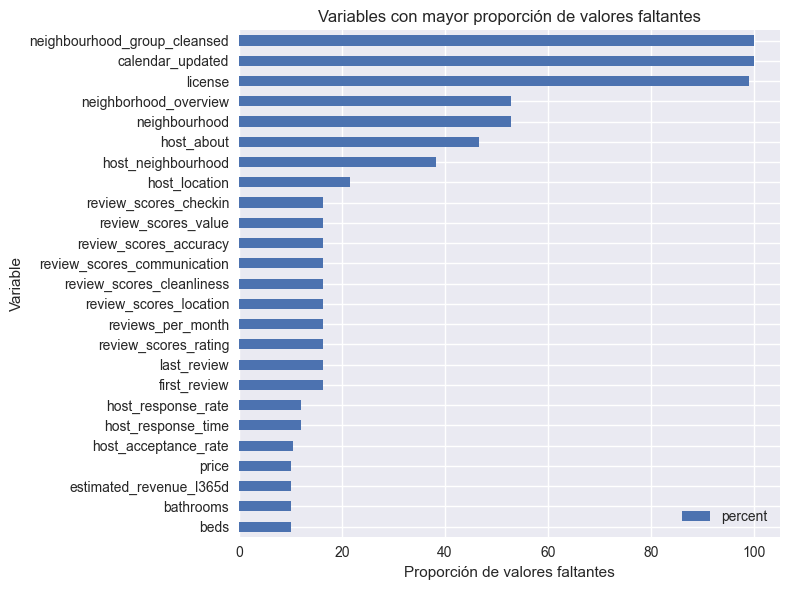

In [9]:
# Visualización del top de variables con mayor porcentaje de faltantes
top_missing =  missing_table.head(25)

ax = top_missing.sort_values('percent').plot.barh(y='percent', figsize=(8, 6))
ax.set_xlabel('Proporción de valores faltantes')
ax.set_ylabel('Variable')
ax.set_title('Variables con mayor proporción de valores faltantes')

plt.tight_layout()
plt.show()


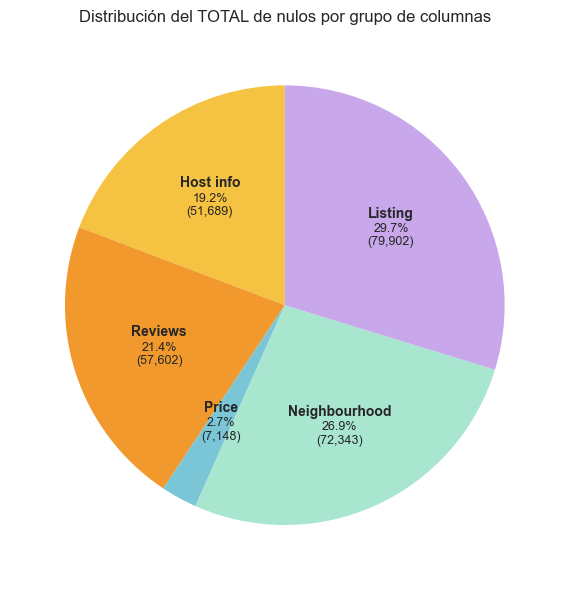

 Host info: 51,689 nulos (19.2378%)
   Reviews: 57,602 nulos (21.4386%)
     Price: 7,148 nulos (2.6604%)
Neighbourhood: 72,343 nulos (26.9249%)
   Listing: 79,902 nulos (29.7383%)
------------------------------
     TOTAL: 268,684 nulos (100.0000%)
['id']


In [10]:
import matplotlib.pyplot as plt

# === 1) DEFINIR GRUPOS ===
# Host: todas las columnas que empiezan con 'host_'
keywords_host = ['host', 'night']
host_cols = [
    c for c in df.columns
    if any(kw in c.lower() for kw in keywords_host)
]

keywords_listing = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'picture_url', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'calendar_updated', 'calendar_last_scraped', 'license', 'instant_bookable','availability', 'night','tasa_ocupacion','estimated_occupancy_l365d']
listing_cols = [
    c for c in df.columns
    if any(kw in c.lower() for kw in keywords_listing)
]

review_cols = [c for c in df.columns if 'review' in c.lower()]

keywords_barrio = ['neighbourhood', 'neighborhood_overview']

location_cols = [
    c for c in df.columns
    if any(kw in c.lower() for kw in keywords_barrio)   # contiene alguna keyword
    and c not in host_cols                              # NO está en host
]



# Price: si existe
price_cols = ['price','estimated_revenue_l365d'] if 'price' in df.columns else []

# Otros: todo lo que no entra en los grupos anteriores
grouped = set(host_cols + review_cols + price_cols  + location_cols + listing_cols)
other_cols = [c for c in df.columns if c not in grouped]

def nulls_in(cols):
    return df[cols].isna().sum().sum() if cols else 0

null_host   = nulls_in(host_cols)
null_review = nulls_in(review_cols)
null_price  = nulls_in(price_cols)
null_other  = nulls_in(other_cols)
null_location = nulls_in(location_cols)
null_listing = nulls_in(listing_cols)

total_nulls = null_host + null_review + null_price + null_other  + null_location + null_listing
if total_nulls == 0:
    print("No hay nulos en el dataset.")
else:
    labels = ['Host info', 'Reviews', 'Price', 'Neighbourhood', 'Listing']
    sizes  = [null_host, null_review, null_price, null_location, null_listing]

    colors = ['#F5C242', '#F2992E', '#7AC6D6', '#A8E6CF', '#C9A7EB', '#F8BBD0']

    plt.figure(figsize=(6,6))
    wedges, _ = plt.pie(
        sizes,
        labels=None,
        colors=colors,
        startangle=90
    )

    for wedge, lab, val in zip(wedges, labels, sizes):
        ang = (wedge.theta2 + wedge.theta1) / 2
        r = 0.60
        x = r * np.cos(np.deg2rad(ang))
        y = r * np.sin(np.deg2rad(ang))
        pct = val / total_nulls * 100

        # Línea superior: label
        plt.text(x, y + 0.06, lab, ha='center', va='center', fontsize=10, weight='bold')

        # Línea inferior: % y cuenta, un poco más abajo para separación
        plt.text(x, y - 0.04, f'{pct:.1f}%\n({val:,})', ha='center', va='center', fontsize=9)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Distribución del TOTAL de nulos por grupo de columnas')
    plt.tight_layout()
    plt.show()


total_pct = 0
for lab, val in zip(labels, sizes):
    pct = val / total_nulls * 100
    total_pct += pct
    print(f'{lab:>10}: {val:,} nulos ({pct:.4f}%)')

print('-' * 30)
print(f'{"TOTAL":>10}: {total_nulls:,} nulos ({total_pct:.4f}%)')

print(other_cols)


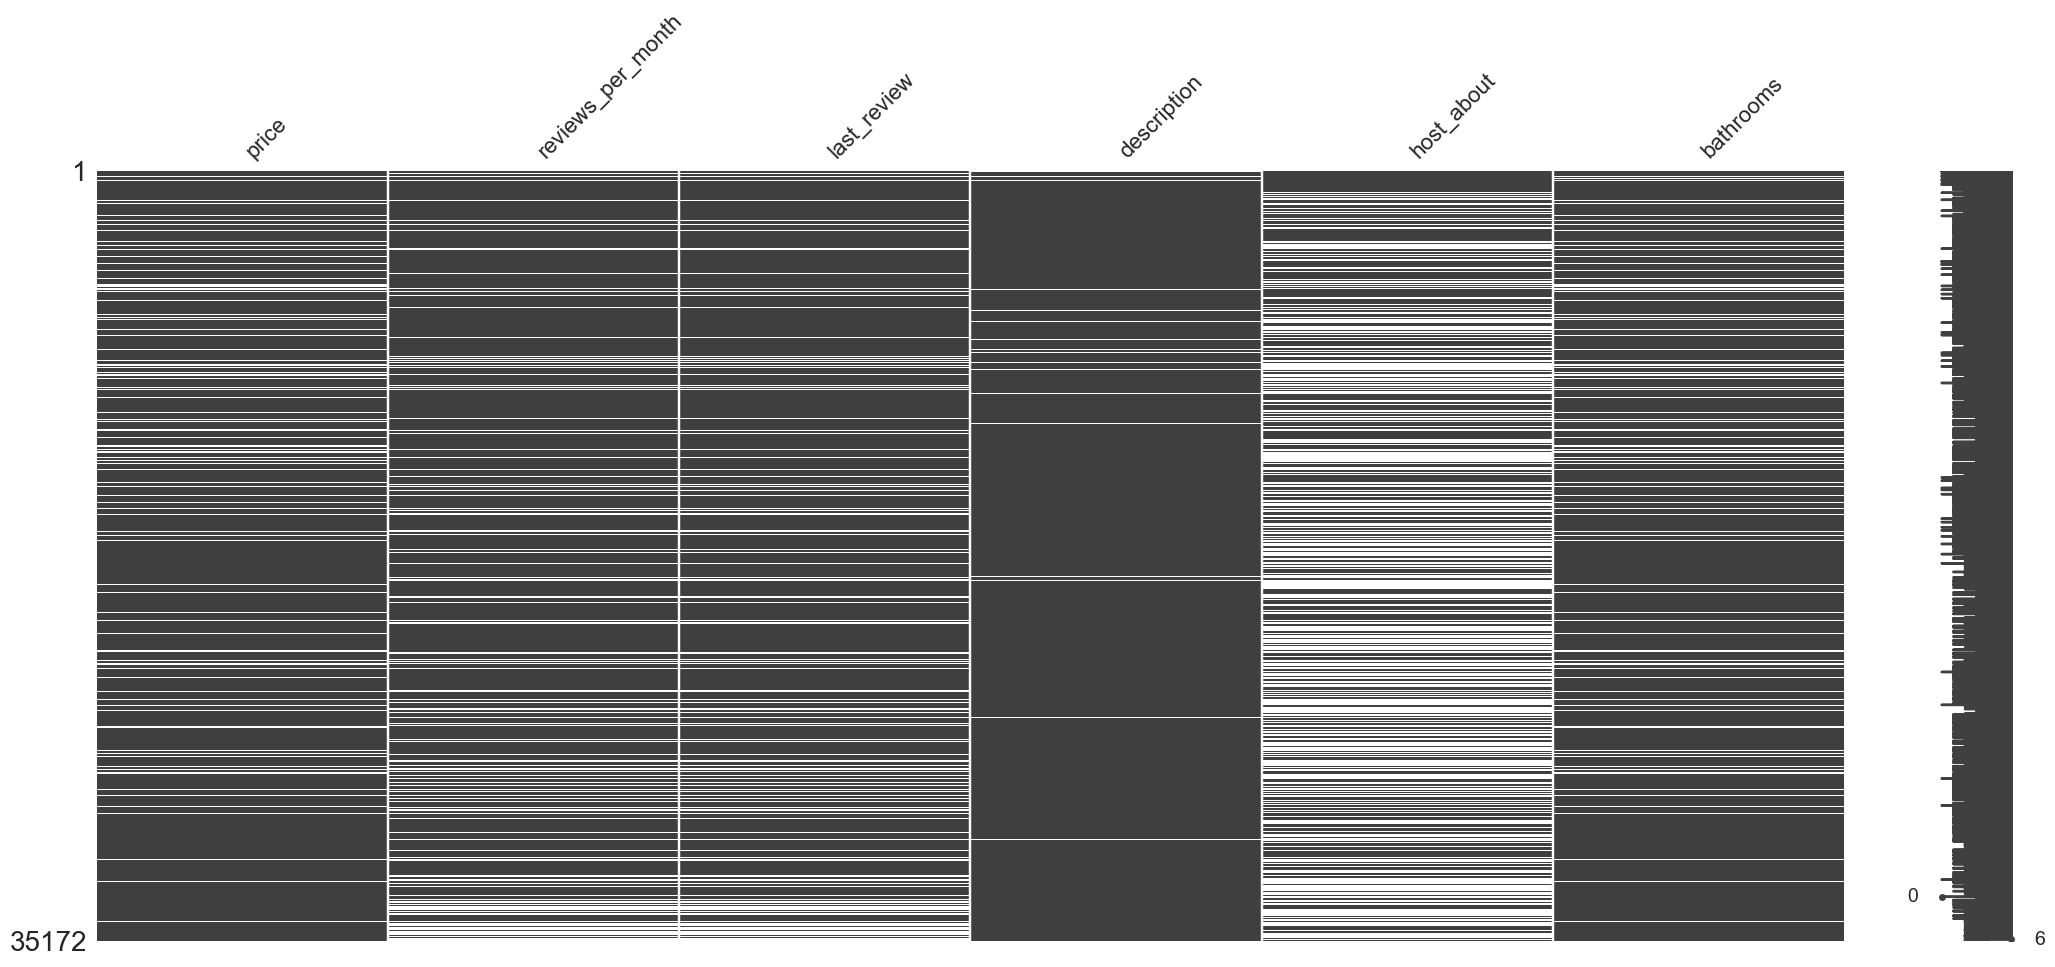

In [11]:

msno.matrix(df[['price', 'reviews_per_month', 'last_review', 'description', 'host_about', 'bathrooms']])
plt.show()


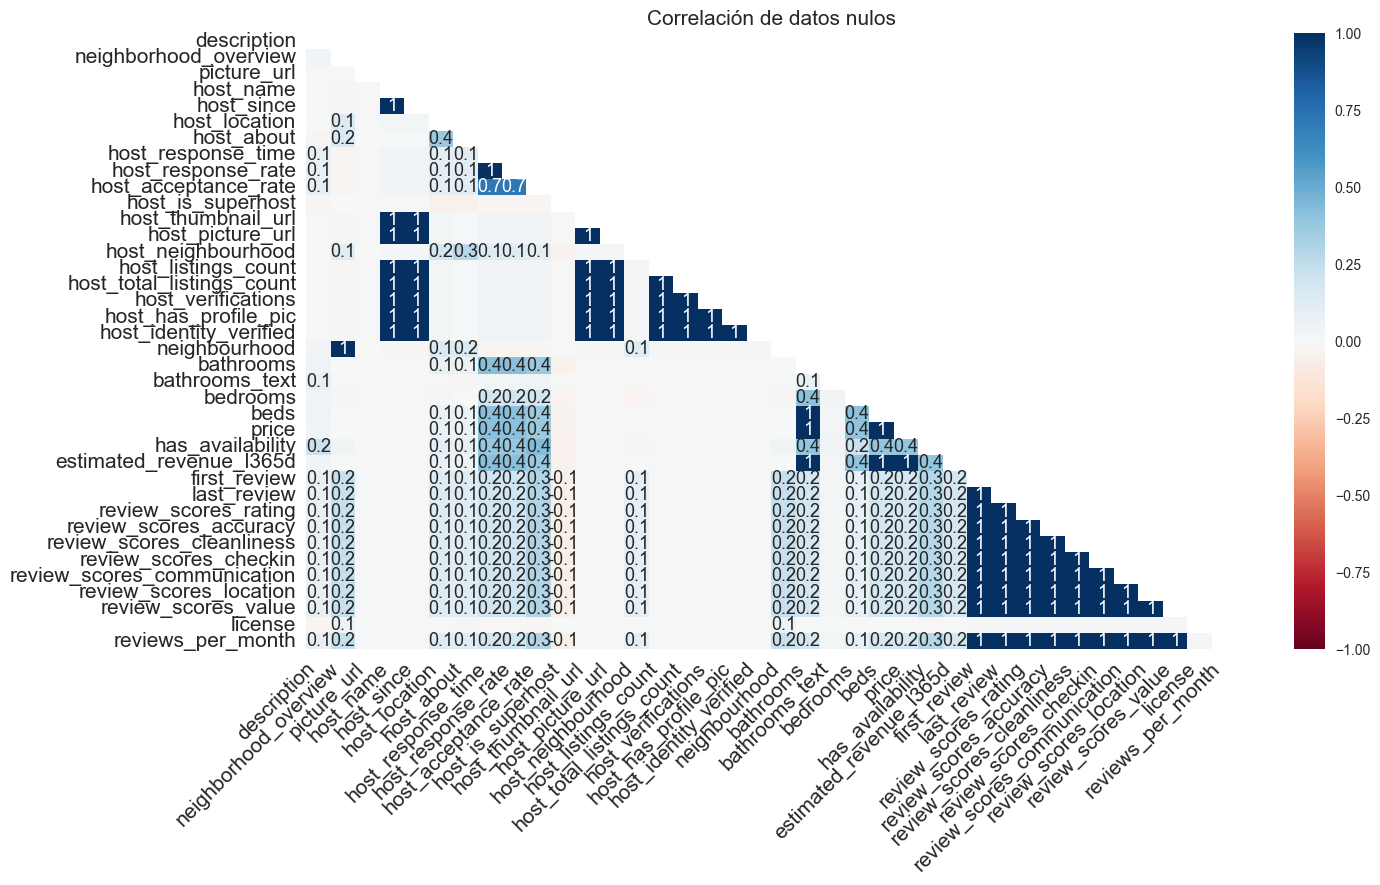

In [12]:
msno.heatmap(df, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

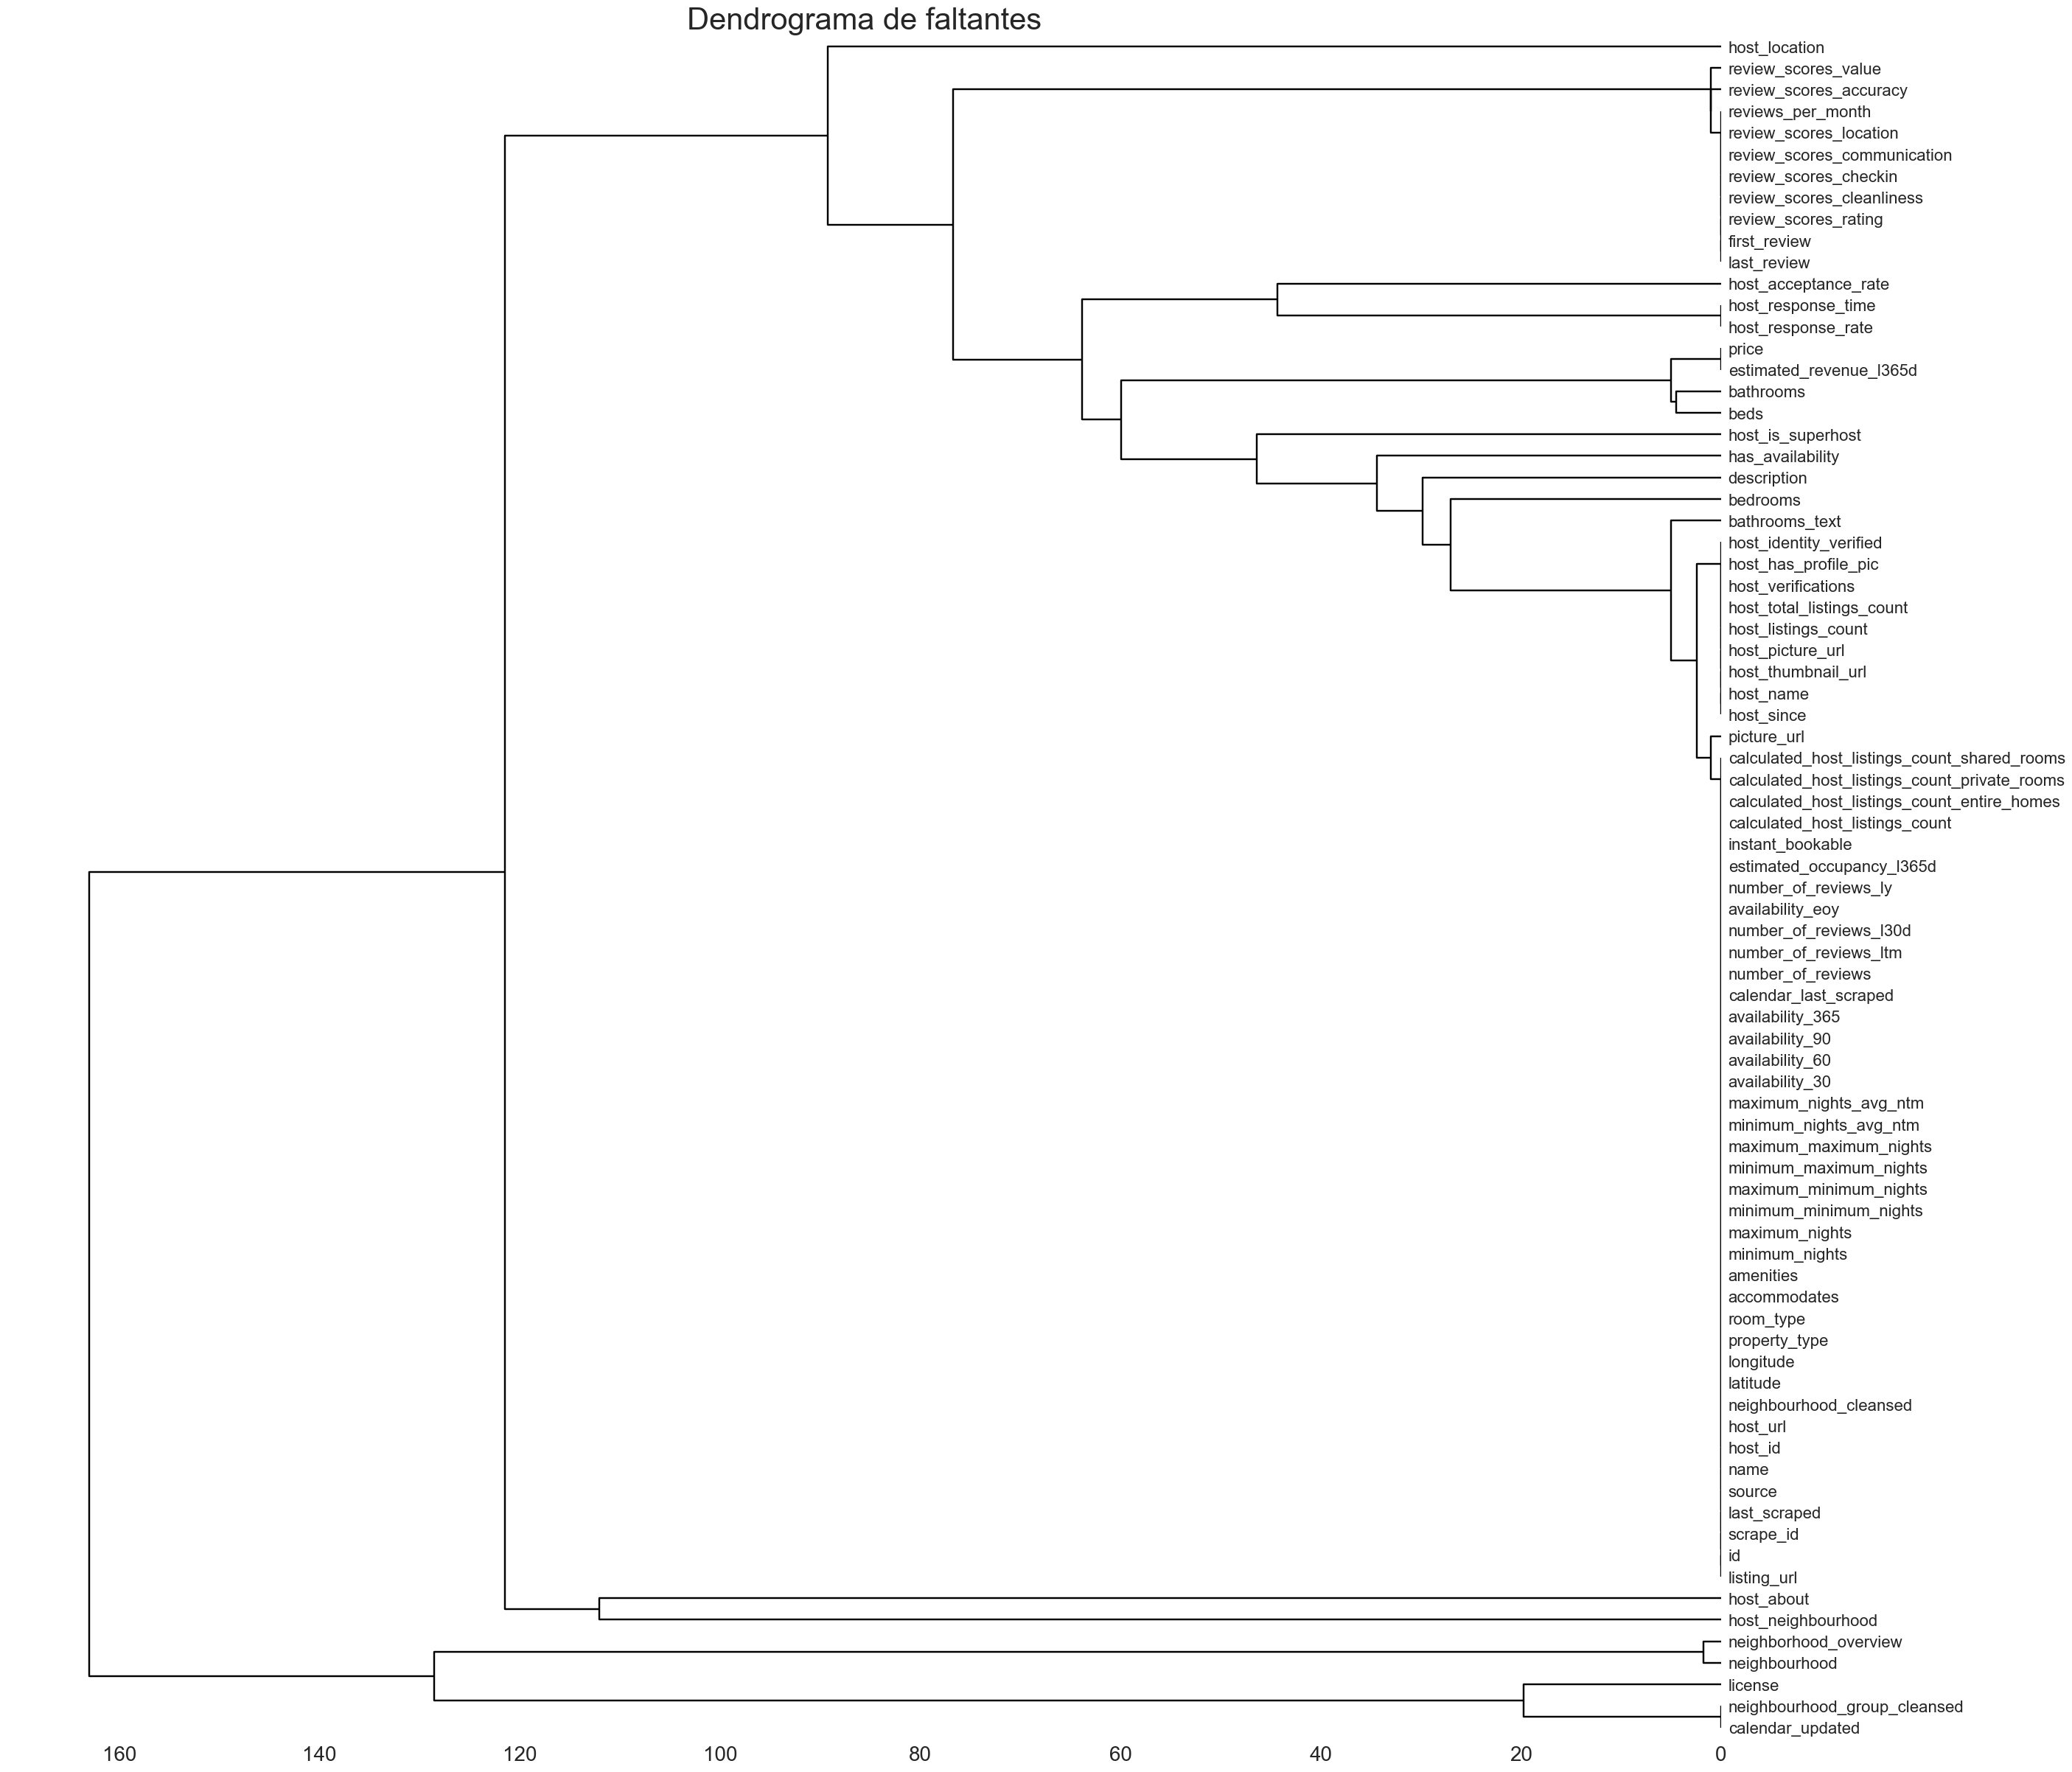

In [13]:
msno.dendrogram(df, figsize=(30,30))
plt.title('Dendrograma de faltantes', fontsize=30)
plt.show()

In [14]:
NULL_TOKENS = {"", " ", "nan", "NaN", "null", "Null", "NULL", "none", "None", "NONE"}

def missing_mask(series: pd.Series) -> pd.Series:
    """True cuando el valor debe considerarse nulo (NaN real o string vacío)."""
    base_mask = series.isna()
    string_mask = series.astype(str).str.strip().isin(NULL_TOKENS)
    return base_mask | string_mask

# Construcción de features de referencia 
def build_numeric_features(df: pd.DataFrame, min_valid_frac: float = 0.50) -> dict:
    numeric_features = {}
    for col in df.columns:
        series = df[col]
        cleaned = (
            series.astype(str)
                  .str.replace(r"[^\d\.\-]", "", regex=True)
                  .replace("", pd.NA)
        )
        numeric = pd.to_numeric(cleaned, errors="coerce")
        if numeric.notna().mean() >= min_valid_frac:
            numeric_features[col] = numeric
    return numeric_features

def build_categorical_features(df: pd.DataFrame, max_cardinality: int = 30) -> dict:
    categorical_features = {}
    for col in df.columns:
        series = df[col]
        if series.dtype == "O" or series.dtype == "bool":
            if 1 <= series.dropna().nunique() <= max_cardinality:
                categorical_features[col] = series.fillna("Missing")
    return categorical_features

numeric_features = build_numeric_features(df)
categorical_features = build_categorical_features(df)

# Medidas de asociación entre patrón de nulos y otras columnas 
def numeric_effect(nan_mask: pd.Series, series: pd.Series):
    available = series.notna()
    if available.sum() == 0:
        return None
    miss = nan_mask & available
    present = (~nan_mask) & available
    if miss.sum() == 0 or present.sum() == 0:
        return None
    diff = series[miss].mean() - series[present].mean()
    std = series[available].std()
    if pd.isna(std) or std == 0:
        return None
    return abs(diff) / std  # diferencia estandarizada

def categorical_effect(nan_mask: pd.Series, series: pd.Series):
    miss = nan_mask
    present = ~nan_mask
    if miss.sum() == 0 or present.sum() == 0:
        return None
    freq_miss = series[miss].value_counts(normalize=True)
    freq_present = series[present].value_counts(normalize=True)
    combined = pd.concat([freq_miss, freq_present], axis=1, keys=["missing", "present"]).fillna(0)
    combined["diff"] = (combined["missing"] - combined["present"]).abs()
    return combined["diff"].max()

# Clasificación MCAR / MAR / MNAR
missing_counts = {col: missing_mask(df[col]).sum() for col in df.columns}
missing_pct = {col: round(count / len(df) * 100, 2) for col, count in missing_counts.items()}
missing_summary = (
    pd.DataFrame({"missing": missing_counts, "missing_pct": missing_pct})
      .query("missing > 0")
      .sort_values("missing_pct", ascending=False)
)

results = []
row_count = len(df)

for col in missing_summary.index:
    mask = missing_mask(df[col])

    if missing_summary.loc[col, "missing"] == row_count:
        results.append({
            "column": col,
            "missing": missing_summary.loc[col, "missing"],
            "missing_pct": missing_summary.loc[col, "missing_pct"],
            "category": "Estructural",
            "driver": None,
            "effect_size": None,
            "notes": "100% ausente en el scrape; indicio de campo no disponible en la fuente."
        })
        continue

    best_effect = 0
    best_driver = None
    best_type = None

    for driver, series in numeric_features.items():
        if driver == col:
            continue
        effect = numeric_effect(mask, series)
        if effect is not None and effect > best_effect:
            best_effect = effect
            best_driver = driver
            best_type = "numérico"

    for driver, series in categorical_features.items():
        if driver == col:
            continue
        effect = categorical_effect(mask, series)
        if effect is not None and effect > best_effect:
            best_effect = effect
            best_driver = f"{driver} (categoría)"
            best_type = "categórico"

    if best_effect < 0.05 or best_driver is None:
        category = "MCAR"
        notes = "No se detectan asociaciones significativas con variables observadas."
    else:
        if missing_summary.get("missing_pct", pd.Series()).get(best_driver.replace(" (categoría)", ""), 0) < 50:
            category = "MAR"
            notes = f"Patrón de ausencias relacionado con {best_driver}; efecto {best_effect:.2f} ({best_type})."
        else:
            category = "MNAR"
            notes = (
                f"Hay asociación (efecto {best_effect:.2f}) pero el driver también está muy incompleto "
                "o depende de factores no observados; se clasifica como MNAR."
            )

    results.append({
        "column": col,
        "missing": missing_summary.loc[col, "missing"],
        "missing_pct": missing_summary.loc[col, "missing_pct"],
        "category": category,
        "driver": best_driver,
        "effect_size": round(best_effect, 3) if best_effect is not None else None,
        "notes": notes
    })

missing_classification = pd.DataFrame(results).sort_values(["category", "missing_pct"], ascending=False)
missing_classification


,column,missing,missing_pct,category,driver,effect_size,notes
2,license,34783,98.8900,MAR,id,0.9990,Patrón de ausencias relacionado con id; efecto...
3,neighborhood_overview,18587,52.8500,MAR,id,0.8110,Patrón de ausencias relacionado con id; efecto...
4,neighbourhood,18584,52.8400,MAR,id,0.8110,Patrón de ausencias relacionado con id; efecto...
5,host_about,16372,46.5500,MAR,host_id,0.6770,Patrón de ausencias relacionado con host_id; e...
6,host_neighbourhood,13451,38.2400,MAR,host_id,0.6480,Patrón de ausencias relacionado con host_id; e...
7,host_location,7553,21.4700,MAR,host_id,1.0280,Patrón de ausencias relacionado con host_id; e...
8,review_scores_location,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
9,review_scores_communication,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
10,review_scores_cleanliness,5760,16.3800,MAR,host_acceptance_rate,1.0790,Patrón de ausencias relacionado con host_accep...
11,review_scores_accuracy,5761,16.3800,MAR,review_scores_cleanliness,9.7900,Patrón de ausencias relacionado con review_sco...


**Interpretación inicial:** La ausencia de `reviews_per_month` suele darse en listados sin reseñas recientes, sugiriendo un mecanismo MAR (dependiente de `number_of_reviews`).


## 2.1 Tratamiento de nulos

### 2.1.0 Eliminamos columnas de identificadores / urls / contenido textual sin procesar

- id
- listing_url
- scrape_id
- name  (texto subjetivo)
- description
- picture_url
- host_url
- host_name
- host_location (texto no estandarizado)
- host_about
- host_thumbnail_url
- host_picture_url
- host_has_profile_pic
- source


In [15]:
df = df.drop(columns=['id', 'listing_url','scrape_id','name','description','picture_url', 'host_url','host_name','host_location','host_about','host_thumbnail_url','host_picture_url','host_has_profile_pic','source'] )


### 2.1.1 Las columnas

- neighbourhood_group_cleansed (100% nulos)
- calendar_updated (100% nulos)
- license (99% nulos)

las eliminamos

In [16]:
df = df.drop(columns=['neighbourhood_group_cleansed', 'calendar_updated','license'] )

### 2.1.2 La columna booleanas

- Si has_availability es nula, la completamos con yes si la suma de availability_30, availability_60, availability_90 y availability_365 es distinta de cero y con no si la suma es igual a cero
- Si host_is_superhost no esta definida, significa que puede ser un listing nuevo que aun no fue evaluado por airbnb para ver si califica o no, con lo cual es importante diferenciar de un no. Para eso a los nulos le ponemos no, pero creamos una nueva columna llamada was_evaluated_for_superhost para diferenciarlos de los ya evaluados

In [17]:
availability_cols = ['availability_30','availability_60','availability_90','availability_365']
availability_sum = df[availability_cols].sum(axis=1)
has_availability_isna = df['has_availability'].isna()
has_availability_true = (availability_sum != 0) & (has_availability_isna)
has_availability_false = (availability_sum == 0) & (has_availability_isna)

df.loc[has_availability_true,'has_availability'] = 't'
df.loc[has_availability_false,'has_availability'] = 'f'

df['was_evaluated_for_superhost'] = ~df['host_is_superhost'].isna()

boolean_cols = df.columns.intersection(
    ['host_has_profile_pic',
     'host_identity_verified',
     'instant_bookable',
     'has_availability','host_is_superhost'])

df.loc[:, boolean_cols] = df.loc[:, boolean_cols].replace({'t': 'yes', 'f': 'no'})

df['host_is_superhost'] = df['host_is_superhost'].fillna('no')

print(df['host_is_superhost'].unique())
print(df['was_evaluated_for_superhost'].unique())


['yes' 'no']
[ True False]


### 2.1.2 Las columnas neighbourhood (52% nulos), neighbourhood_overview (52% nulos), host_location (46% nulos) y host_about (46% nulos)

- La columna neighbourhood completamos con la del valor codificado neighbourhood_cleansed que es el valor ya codificado de la ubicacion
- La columna neighbourhood_overview le asignamos la clasificacion "not defined"
- La columna host_location y host_about fueron eliminadas con anterioridad por no ser reelevantes para el problema a resolver


In [18]:
df['neighbourhood'] = df['neighbourhood'].fillna(df['neighbourhood_cleansed'])

cols = ['neighborhood_overview', 'host_neighbourhood']
df[cols] = (
    df[cols]
      .astype('string')                         # cast a string nativo
      .replace(r'^\s*$', pd.NA, regex=True)     # "" o solo espacios → NA
      .fillna('not-defined')                    # completar NA
)

get_missing(df)


,missing,percent
review_scores_value,5761,16.3800
review_scores_accuracy,5761,16.3800
review_scores_checkin,5760,16.3800
last_review,5760,16.3800
review_scores_rating,5760,16.3800
review_scores_cleanliness,5760,16.3800
review_scores_communication,5760,16.3800
review_scores_location,5760,16.3800
first_review,5760,16.3800
reviews_per_month,5760,16.3800


### 2.1.2 Las columnas de reviews

Podemos observar que el porcentaje de nulos de las columnas asociadas a las reviews es el mismo (16.7%) y coincide con que no hay ni fecha de first_review ni fecha de last_review, esto nos muestra que posiblemente esos listings aun no tengan ninguna review asociada, con lo cual tiene sentido que sean nulos las reviews por aspecto del alojamiento. Lo que vamos a hacer es asignarle un cero pero ademas vamos a crear una nueva columna que indique si el listing tiene reviews o no.

- review_scores_accuracy	    4725	16.7600
- review_scores_value	        4725	16.7600
- reviews_per_month	            4724	16.7600
- first_review	                4724	16.7600
- last_review	                4724	16.7600
- review_scores_rating	        4724	16.7600
- review_scores_location	    4724	16.7600
- review_scores_communication	4724	16.7600
- review_scores_checkin	        4724	16.7600
- review_scores_cleanliness	    4724	16.7600


In [19]:
# ————————————————————————————————————————————————————————————————
# Reviews: normalización de scores y derivadas sin fuga
# Qué hace:
#   - Convierte review_scores_* a numérico
#   - Define has_reviews (0/1) y pone scores=0 si no hay reviews
#   - Crea días desde primera/última review usando last_scraped por fila
#   - Completa reviews_per_month=0 si no hay reviews
#   - Elimina fechas crudas de review
# ————————————————————————————————————————————————————————————————

review_score_columns = [c for c in df.columns if c.startswith("review_scores_")]
df[review_score_columns] = df[review_score_columns].apply(pd.to_numeric, errors='coerce')

has_any_review_count   = (df["number_of_reviews"] > 0)
has_first_review_date  = df["first_review"].notna()
has_last_review_date   = df["last_review"].notna()
has_reviews_per_month  = (df["reviews_per_month"].fillna(0) > 0)

df["has_reviews_flag"] = (
    has_any_review_count | has_first_review_date | has_last_review_date | has_reviews_per_month
).astype("int8")

# 3) si no hay reviews, los puntajes valen 0
if review_score_columns:
    df.loc[df["has_reviews_flag"] == 0, review_score_columns] = 0.0

# 4) días desde primera / última review (usando last_scraped por fila)
days_since_first_review = (df["last_scraped"] - df["first_review"]).dt.days
df["days_since_first_review"] = (
    days_since_first_review.where(df["has_reviews_flag"] == 1, -1)
                           .fillna(-1)
                           .clip(lower=-1)
                           .astype("int32")
)

days_since_last_review = (df["last_scraped"] - df["last_review"]).dt.days
df["days_since_last_review"] = (
    days_since_last_review.where(df["has_reviews_flag"] == 1, -1)
                          .fillna(-1)
                          .clip(lower=-1)
                          .astype("int32")
)

df.loc[(df["has_reviews_flag"] == 0) & (df["reviews_per_month"].isna()), "reviews_per_month"] = 0.0
df.drop(columns=["first_review", "last_review"], inplace=True)

get_missing(df)


,missing,percent
host_response_time,4229,12.0200
host_response_rate,4229,12.0200
host_acceptance_rate,3712,10.5500
estimated_revenue_l365d,3574,10.1600
price,3574,10.1600
bathrooms,3570,10.1500
beds,3568,10.1400
bedrooms,727,2.0700
bathrooms_text,24,0.0700
host_identity_verified,6,0.0200


### 2.1.2 Tratamiento para bathrooms_text, bedrooms, beds

La lógica para realizar el tratamiento de nulos de estas columnas es la siguiente: Las características como **room_type**, **bathrooms_text**, **bedrooms** y **beds** tienen cierto grado de relación natural. Es por eso que se pretende aprovechar esto para realizar el rellenado de los faltantes.

1. Paso 1: Se va a calcular la **MODA** de cada **room_type**. Luego a cada alojamiento que le falte **bathrooms_text**, se le va a asignar la **MODA** cuyo **room_type** sea el mismo. 

2. Paso 2: Una vez completados los nulos de **bathrooms_text**, se va a aprovechar esto para completar los nulos de **bedrooms**. Se va a calcular la **MODA** de cada **bathrooms_text**. Luego a cada alojamiento que le falte **bedrooms**, se le va a asignar la **MODA** cuyo **bathrooms_text** sea el mismo.

3. Paso 3: Una vez completados los nulos de **bedrooms**, se va a aprovechar esto para completar los nulos de **beds**. Se va a calcular la **MODA** de cada **bedrooms**. Luego a cada alojamiento que le falte **beds**, se le va a asignar la **MODA** cuyo **bedrooms** sea el mismo.


In [20]:
# remove_nan_1()
# 
# Entradas
#           df            DataFrame
#           nan_feature   Nombre de la feature que posee los nulos a reemplazar
#           ref_feature   Nombre de la feature sobre la cual calcular las modas
#
# Salida:
#           df            DataFrame actualizado
#
# El df recibido se modifica de manera de que se reemplazan todos los nulos encontrados
# en la columna nan_feature con las modas (previo dropeo de nan) calculadas para esa feature
# agrupando primero por ref_feature
#
# Ej: df = remove_nan_1(df, 'beds', 'bedrooms')
#
# 1) dropea los beds nan
# 2) agrupa las muestras por bedrooms y calcula la MODA de cada grupo
# 3) donde habia nan de beds le pone la MODA acorde al bedroom que pose esa muestra
def remove_nan_1(df, nan_feature, ref_feature):

    # Se pretende que la ref_feature no posea nan
    if len(df[df[ref_feature].isna()]) > 0:
      raise Exception(f'{ref_feature} posee nulos')
    
    _df = df.copy()

    # Si no hay nulos en nan_feature, no hace falta continuar  
    n_missing_before = len(df[df[nan_feature].isna()])
    if n_missing_before == 0:
        print(f"No hay faltantes de {nan_feature}")
        return _df
    
    # Dropear los nan
    _df_no_nan = _df.dropna(subset=[nan_feature])
    
    # Calcular la moda usando ref_feature
    moda = _df_no_nan.groupby(ref_feature)[nan_feature].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

    # Reemplazar
    _df.loc[_df[nan_feature].isna(), nan_feature] = _df.loc[_df[nan_feature].isna(), ref_feature].map(moda)
    n_faltantes_after = len(_df[_df[nan_feature].isna()])
    print(f"Numero de faltantes de {nan_feature}: antes={n_missing_before}, despues={n_faltantes_after}")
    
    # Si aun quedan nulos significa que no hubo match exacto entre las posibles modas y el valor de una cierta
    # fila
    nan_indices = _df[_df[nan_feature].isna()].index
    for index in nan_indices:
      v = _df.loc[index, ref_feature]
      idx_min = 0
      min = abs(v - moda.loc[idx_min])
      for idx_m, value_m in moda.items():
        d = abs(v - value_m)
        if d < min:
          idx_min = idx_m
          min = d
      _df.loc[index, nan_feature] = moda.loc[idx_min]
      print(f"valor original no encontrado: {v}, valor usado: {moda.loc[idx_min]}, indice: {idx_min}")
      print(f"Numero de faltantes de {nan_feature}: antes={n_missing_before}, despues={len(_df[_df[nan_feature].isna()])}")
    return _df

In [21]:
df = remove_nan_1(df, nan_feature = 'bathrooms_text', ref_feature = 'room_type')
df = remove_nan_1(df, nan_feature = 'bedrooms', ref_feature = 'bathrooms_text')
df = remove_nan_1(df, nan_feature = 'beds', ref_feature = 'bedrooms')

get_missing(df)

Numero de faltantes de bathrooms_text: antes=24, despues=0
Numero de faltantes de bedrooms: antes=727, despues=0
Numero de faltantes de beds: antes=3568, despues=1
valor original no encontrado: 35.0, valor usado: 30.0, indice: 19.0
Numero de faltantes de beds: antes=3568, despues=0


,missing,percent
host_response_time,4229,12.0200
host_response_rate,4229,12.0200
host_acceptance_rate,3712,10.5500
price,3574,10.1600
estimated_revenue_l365d,3574,10.1600
bathrooms,3570,10.1500
host_listings_count,6,0.0200
host_identity_verified,6,0.0200
host_total_listings_count,6,0.0200
host_verifications,6,0.0200


### 2.1.3 Antiguedad del host

Calculamos host_days_active como la diferencia en días entre last_scraped (fecha “hoy” del dataset) y host_since (fecha en que el host abrió su cuenta). Esto mide la antigüedad real del host en la plataforma.

Si la fecha no está disponible, imputamos -1 para marcar “desconocido” sin confundirlo con 0 días.

Creamos el flag host_is_new (=1 si la antigüedad está entre 0 y 89 días, inclusive) para capturar el comportamiento típico de hosts nuevos: menos reseñas, menor inercia de demanda y mayor incertidumbre.

Estas variables sirven para modelar diferencias de performance entre hosts nuevos vs. establecidos, sin usar señales de futuro (evita leakage).

In [22]:
df['host_days_active'] = (df['last_scraped'] - df['host_since']).dt.days
df['host_days_active'] = df['host_days_active'].fillna(-1).astype('int32')

df['host_is_new'] = (df['host_days_active'] >= 0) & (df['host_days_active'] < 90)
df['host_is_new'] = df['host_is_new'].astype('int8')



### 2.1.4 Chequeo de nulos antes del split

Nulos previos al split con pre procesamiento de nulos

In [23]:
get_missing(df)


,missing,percent
host_response_time,4229,12.0200
host_response_rate,4229,12.0200
host_acceptance_rate,3712,10.5500
price,3574,10.1600
estimated_revenue_l365d,3574,10.1600
bathrooms,3570,10.1500
host_listings_count,6,0.0200
host_verifications,6,0.0200
host_total_listings_count,6,0.0200
host_identity_verified,6,0.0200


### 2.1.4 Split del dataset

Tenemos en cuenta de que todos los listing del mismo host no queden divididos
Spliteamos en este punto para evitar dataleakage

In [24]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['host_id']))

df_train = df.iloc[train_idx].copy()
df_test  = df.iloc[test_idx].copy()

# sanity check: no hay host_id compartidos
assert set(df_train.host_id) & set(df_test.host_id) == set()

print(df.shape, df_test.shape, df_train.shape)

df_train.drop(columns=['host_id'], inplace=True)
df_test.drop(columns=['host_id'], inplace=True)

(35172, 66) (6988, 66) (28184, 66)


## 3. Distribuciones y visualizaciones clave


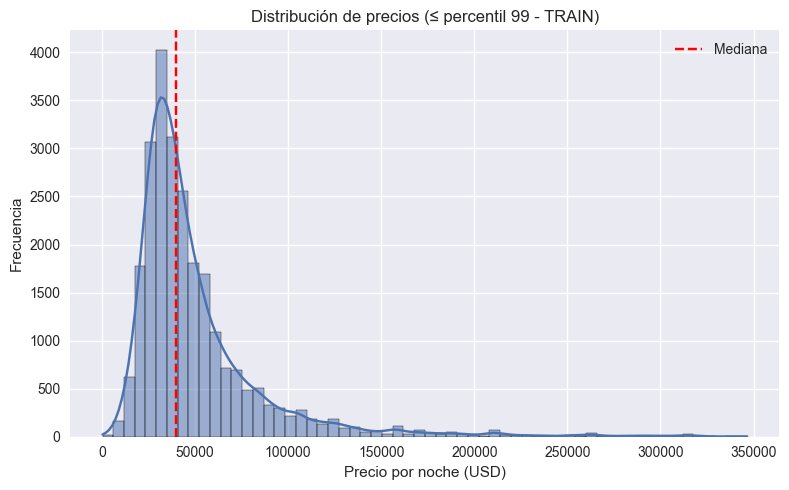

In [25]:
p99_price = df_train['price'].quantile(0.99)

mask_train = df_train['price'] <= p99_price
price_train_p99 = df_train.loc[mask_train, 'price'].dropna()

sns.histplot(price_train_p99, bins=60, kde=True)
plt.axvline(df_train['price'].median(), color='red', linestyle='--', label='Mediana')
plt.title('Distribución de precios (≤ percentil 99 - TRAIN)')
plt.xlabel('Precio por noche (USD)')
plt.ylabel('Frecuencia')
plt.legend()
plt.tight_layout()
plt.show()


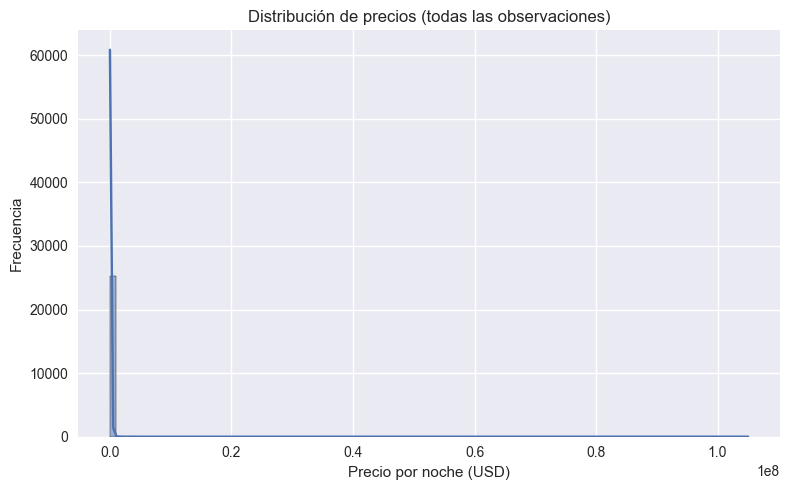

In [26]:
sns.histplot(df_train['price'].dropna(), bins=100, kde=True)
plt.title('Distribución de precios (todas las observaciones)')
plt.xlabel('Precio por noche (USD)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


In [27]:
# Skewness de precios para evaluar la asimetría
price_series = df_train['price'].dropna()
price_skew = price_series.skew()
positive_prices = price_series[price_series > 0]
price_log_skew = np.log1p(positive_prices).skew() if not positive_prices.empty else np.nan
print(f'Skewness (precio bruto): {price_skew:.3f}')
print(f'Skewness (log1p del precio): {price_log_skew:.3f}')


Skewness (precio bruto): 52.733
Skewness (log1p del precio): 1.780


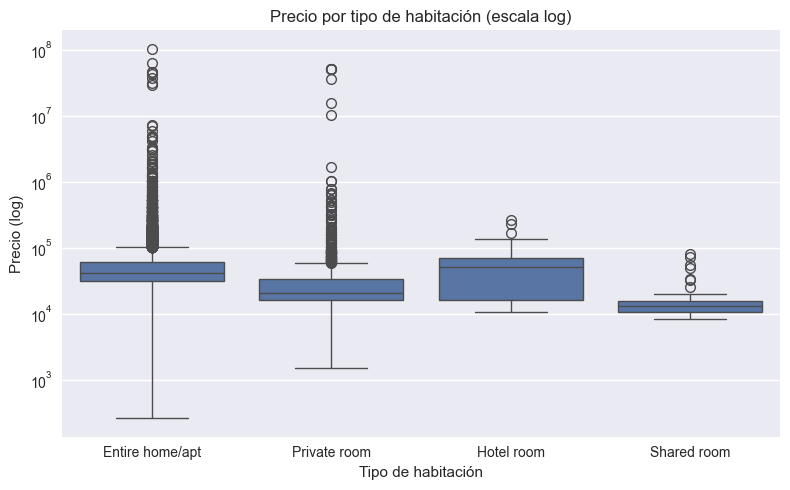

In [28]:
sns.boxplot(data=df_train, x='room_type', y='price')
plt.yscale('log')
plt.title('Precio por tipo de habitación (escala log)')
plt.xlabel('Tipo de habitación')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


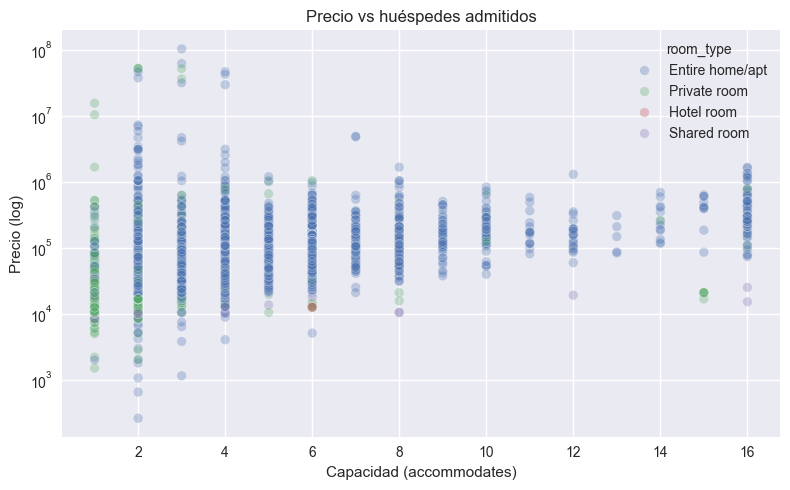

In [29]:
# Precio versus capacidad
sns.scatterplot(data=df_train, x='accommodates', y='price', hue='room_type', alpha=0.3)
plt.yscale('log')
plt.title('Precio vs huéspedes admitidos')
plt.xlabel('Capacidad (accommodates)')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


## Auditoría del target (¿está “contaminado” por disponibilidad o reviews?)

Este bloque verifica si nuestra variable objetivo estimated_occupancy_l365d está implícitamente derivada de señales que no podemos usar en cold-start (p. ej., availability_365 o métricas de reviews). La idea es detectar fuga de información (data leakage) antes de modelar.

Qué hace:

Comparación con disponibilidad anual

Calcula approx = 1 - availability_365/365 (una ocupación “aproximada” a partir de la disponibilidad).

Imprime:

corr(y, 1 - avail/365): correlación entre el target y esa aproximación.

max abs diff: máxima diferencia absoluta entre y y approx.

Interpretación:

Si la correlación es muy alta (≈0.9–1.0) y las diferencias son mínimas, el target podría estar derivado de availability ⇒ no usar availability como feature y cuestionar si el target es realmente independiente.

Correlación del target con señales de reviews

Evalúa la correlación de y con number_of_reviews, reviews_per_month, has_reviews y days_since_last_review.

Interpretación:

Correlaciones altas sugieren que el target está fuertemente explicado por historial de reseñas. Para un escenario cold-start, estas columnas deben excluirse de las features (aunque el target siga siendo válido).

Cómo usar los resultados:

Si corr(y, 1 - avail/365) es alta o max abs diff ≈ 0 → el target está prácticamente codificando disponibilidad. Se tiene que evitar por completo availability_* y derivados en el modelo.

Si hay altas correlaciones con reviews → confirma que en el pipeline de features las columnas de reviews no deben entrar (y se debe documentar que el target depende de comportamiento histórico, que un nuevo listing no tiene).

Objetivo final: asegurarnos de que el target que vamos a predecir no esté “mirando el futuro” y que las features del modelo sean válidas para un listing nuevo. Esto evita resultados artificialmente perfectos por fuga.

In [30]:
y_days  = pd.to_numeric(df['estimated_occupancy_l365d'], errors='coerce').astype(float)
y_rate  = (y_days / 365).clip(0, 1)

if 'availability_365' in df.columns:
    approx_rate = 1 - (df['availability_365'] / 365)
    corr = y_rate.corr(approx_rate)
    max_abs_diff = np.nanmax(np.abs(y_rate - approx_rate))
    mae = np.nanmean(np.abs(y_rate - approx_rate))
    print(f"corr(rate, 1 - avail/365) = {corr:.3f} | max abs diff (rate) = {max_abs_diff:.3f} | MAE = {mae:.3f}")

# --- auditoría de correlaciones del target con señales de reviews
def audit_target_source(df: pd.DataFrame, ycol: str = 'estimated_occupancy_l365d'):
    y_rate = (pd.to_numeric(df[ycol], errors='coerce').astype(float) / 365).clip(0, 1)

    report = {}
    if 'availability_365' in df.columns:
        report['corr_with_1_minus_availability'] = y_rate.corr(1 - df['availability_365'] / 365)

    review_like_cols = [
        'number_of_reviews', 'reviews_per_month', 'has_reviews', 'days_since_last_review',
        *[c for c in df.columns if c.startswith('review_scores_')]
    ]

    report.update({
        f'corr_with_{col}': y_rate.corr(pd.to_numeric(df[col], errors='coerce'))
        for col in review_like_cols if col in df.columns
    })

    # devolver ordenado por |correlación| (desc)
    return dict(sorted(report.items(), key=lambda kv: abs(kv[1]), reverse=True))

report = audit_target_source(df)

corr_df = (
    pd.Series(report, name='corr')
      .rename_axis('feature')
      .reset_index()
      .assign(abs_corr=lambda d: d['corr'].abs())
      .sort_values('abs_corr', ascending=False)
      .drop(columns='abs_corr')
)

corr_df  # en Jupyter se ve como tabla


corr(rate, 1 - avail/365) = -0.029 | max abs diff (rate) = 1.000 | MAE = 0.376


,feature,corr
0,corr_with_reviews_per_month,0.7617
1,corr_with_number_of_reviews,0.5707
2,corr_with_review_scores_value,0.3783
3,corr_with_review_scores_cleanliness,0.3748
4,corr_with_review_scores_rating,0.3733
5,corr_with_review_scores_accuracy,0.3713
6,corr_with_review_scores_communication,0.3680
7,corr_with_review_scores_checkin,0.3651
8,corr_with_review_scores_location,0.3643
9,corr_with_days_since_last_review,-0.2619


### Distribuciones de ocupación

Con el siguiente histograma y el resumen se ve:

Rango (días/año): min 0, Q1 = 0, mediana = 28, Q3 = 96, máx = 255.
En tasa: media ≈ 61/365 ≈ 0.17 (17%).
Pico fuerte cerca de 0.7 (= 255/365): eso confirma top-coding/censura superior en 255 días (los que superan el tope quedan “apilados” ahí).

Qué implica para el modelado. Distribución muy sesgada + masa en 0 (Q1=0): hay muchos listings sin ocupación estimada.

Censura arriba (255): una regresión pura a días/365 va a sufrir por el techo.

Por eso, es más robusto ir a clasificación en lugar de regresión directa.

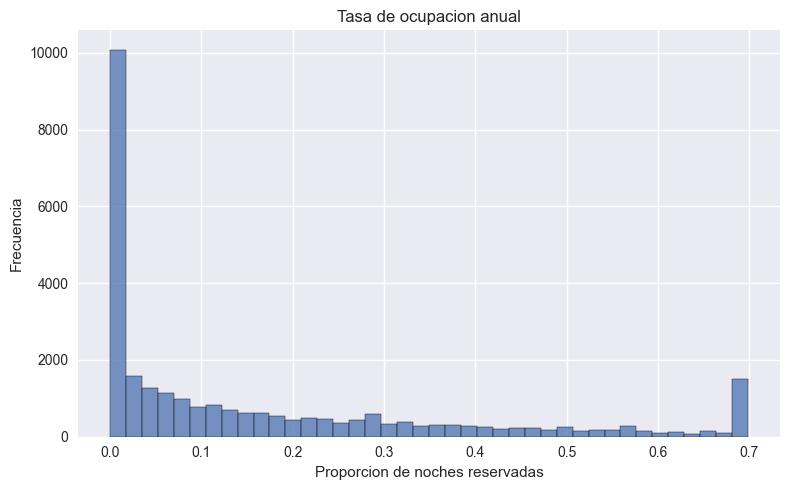

(count   28184.0000
 mean       60.9655
 std        76.0503
 min         0.0000
 25%         0.0000
 50%        28.0000
 75%        96.0000
 max       255.0000
 Name: estimated_occupancy_l365d, dtype: float64,
 255,
 1413,
 0.050134828271359635)

In [31]:
sns.histplot(df_train['estimated_occupancy_l365d']/365, bins=40, kde=False)
plt.title('Tasa de ocupacion anual')
plt.xlabel('Proporcion de noches reservadas')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

s = df_train['estimated_occupancy_l365d']
s.describe(), s.max(), (s==255).sum(), (s>=255).mean()


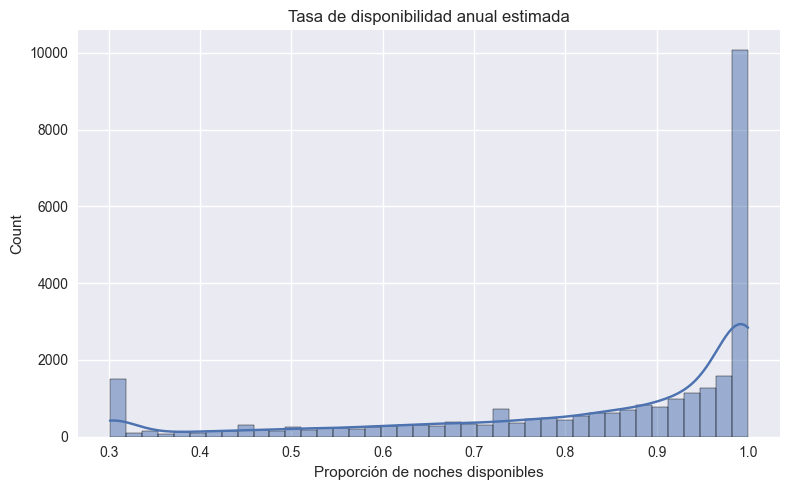

In [32]:
sns.histplot(1 - (df_train['estimated_occupancy_l365d'] / 365), bins=40, kde=True)
plt.title('Tasa de disponibilidad anual estimada')
plt.xlabel('Proporción de noches disponibles')
plt.tight_layout()
plt.show()


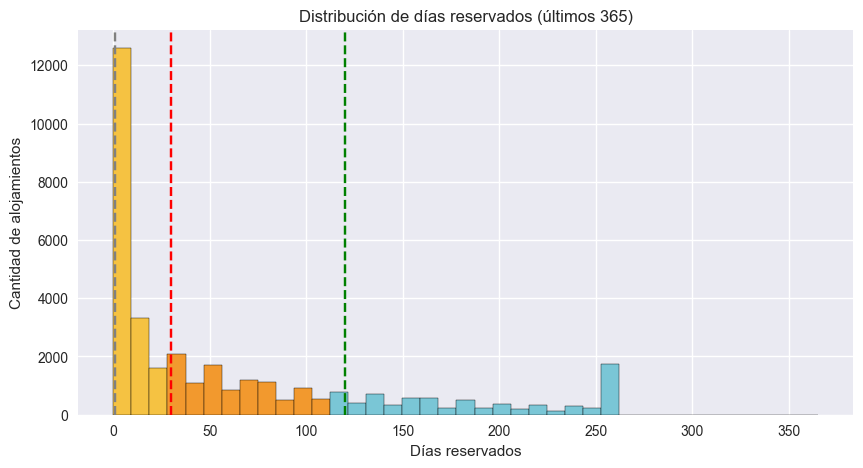

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Días reservados (0–365)
occ_days = pd.to_numeric(df['estimated_occupancy_l365d'], errors='coerce').clip(0, 365)

# 2) Porcentajes por categoría (sobre valores válidos)
n = occ_days.notna().sum()
pct_zero = (occ_days.eq(0)).mean() * 100
pct_low  = ((occ_days.between(1, 30))).mean() * 100
pct_mid  = ((occ_days.between(31, 120))).mean() * 100
pct_high = ((occ_days.ge(121))).mean() * 100

# 3) Histograma con colores por rango (bins finos)
valid = occ_days.dropna()
bins = np.linspace(0, 365, 40)  # podés ajustar la resolución
counts, edges = np.histogram(valid, bins=bins)

def bin_color(lo, hi):
    if hi <= 1:
        return '#BFBFBF'       # zero (gris)
    elif hi <= 30:
        return '#F5C242'       # low (amarillo)
    elif hi <= 120:
        return '#F2992E'       # mid (naranja)
    else:
        return '#7AC6D6'       # high (celeste)

colors = [bin_color(edges[i], edges[i+1]) for i in range(len(edges)-1)]

# 4) Plot
plt.figure(figsize=(10,5))
plt.bar(edges[:-1], counts, width=np.diff(edges), align='edge',
        color=colors, edgecolor='black')

# Líneas guía en los cortes (1, 30, 120)
plt.axvline(1,   color='grey',  ls='--', label='1 día')
plt.axvline(30,  color='red',   ls='--', label='30 días')
plt.axvline(120, color='green', ls='--', label='120 días')

plt.title('Distribución de días reservados (últimos 365)')
plt.xlabel('Días reservados')
plt.ylabel('Cantidad de alojamientos')

# 5) Texto con porcentajes
txt = (f'zero (0): {pct_zero:.1f}%   |   low (1–30): {pct_low:.1f}%   |   '
       f'mid (31–120): {pct_mid:.1f}%   |   high (121–365): {pct_high:.1f}%')


### Correlación orientada a disponibilidad (categóricas codificadas)
Para estudiar los drivers de disponibilidad aplicamos one-hot encoding sobre las variables categóricas y analizamos la correlación con las tasas de ocupación.


/var/folders/qx/hv433zj1493bs872_zqkgspm0000gn/T/ipykernel_63574/1475994796.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'t':1,'true':1,'1':1,'yes':1,'f':0,'false':0,'0':0,'no':0})
/var/folders/qx/hv433zj1493bs872_zqkgspm0000gn/T/ipykernel_63574/1475994796.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'t':1,'true':1,'1':1,'yes':1,'f':0,'false':0,'0':0,'no':0})
/var/folders/qx/hv433zj1493bs872_zqkgspm0000gn/T/ipykernel_63574/1475994796.py:43: FutureWarning: Downcasting behavior in `replace` is dep

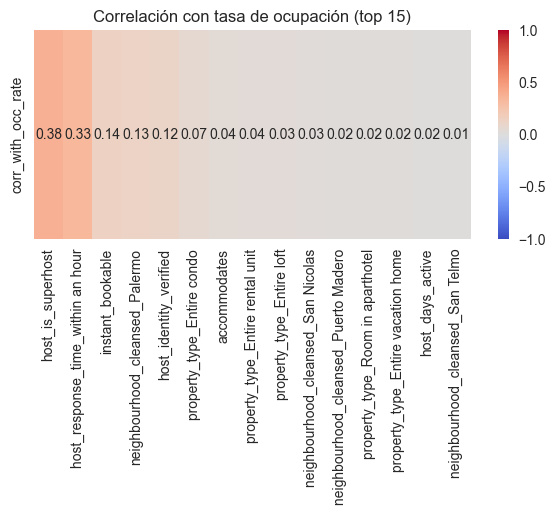

<class 'pandas.core.frame.DataFrame'>
Index: 28184 entries, 1 to 35171
Data columns (total 65 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   last_scraped                                  28184 non-null  datetime64[ns]
 1   neighborhood_overview                         28184 non-null  string        
 2   host_since                                    28184 non-null  datetime64[ns]
 3   host_response_time                            24842 non-null  object        
 4   host_response_rate                            24842 non-null  object        
 5   host_acceptance_rate                          25288 non-null  object        
 6   host_is_superhost                             28184 non-null  object        
 7   host_neighbourhood                            28184 non-null  string        
 8   host_listings_count                           28184 non-null  float64  

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def corr_vs_occupancy(df, target_col='estimated_occupancy_l365d', cold_start=True, topk=15):
    """
    Calcula correlación (Pearson) de features con la tasa de ocupación (target_col/365),
    evitando leakage (excluye availability_* y derivados). No muta df.
    Si cold_start=True, también excluye features basadas en reviews.
    """

    df_ = df.copy()
    y = (df_[target_col] / 365.0).astype(float)

    # --- Excluimos las columnas de availability por leakage / circularidad ---
    leak_cols = [c for c in df_.columns if c.startswith('availability_')] + ['has_availability']

    # Excluimos columnas de reviews por la correlatividad con el target
    review_cols = set()
    if cold_start:
        review_cols |= {c for c in df_.columns if c.startswith('review_scores_')}
        review_cols |= {c for c in df_.columns if c.startswith('number_of_reviews')}
        review_cols |= {'reviews_per_month', 'has_reviews',
                        'days_since_first_review', 'days_since_last_review'}

    drop_cols = set(leak_cols) | review_cols

    base_num = ['accommodates','bedrooms','beds','minimum_nights','maximum_nights',
                'price_imputed','bathrooms','host_response_rate','host_acceptance_rate',
                'host_days_active','amenities_count','price_per_person']

    base_cat = ['room_type','property_type','neighbourhood_cleansed',
                'instant_bookable','host_is_superhost','host_identity_verified',
                'bathroom_is_shared','host_response_time']

    num_cols = [c for c in base_num if c in df_.columns and c not in drop_cols]
    cat_cols = [c for c in base_cat if c in df_.columns and c not in drop_cols]

    # binarios a 0/1 si aparecen como texto
    bin_like = ['instant_bookable','host_is_superhost','host_identity_verified','bathroom_is_shared']
    for c in [c for c in bin_like if c in df_.columns]:
        df_[c] = (df_[c].astype(str).str.lower()
                  .replace({'t':1,'true':1,'1':1,'yes':1,'f':0,'false':0,'0':0,'no':0})
                  .astype('float'))

    X_num = df_[num_cols].apply(pd.to_numeric, errors='coerce')
    X_cat = pd.get_dummies(df_[cat_cols], drop_first=True, dtype=float) if cat_cols else pd.DataFrame(index=df_.index)
    X = pd.concat([X_num, X_cat], axis=1)
    X = X.loc[:, X.std(numeric_only=True) > 0].dropna(axis=1, how='all')

    corr = X.corrwith(y).sort_values(ascending=False)
    corr_df = corr.to_frame(name='corr_with_occ_rate')

    top = corr_df['corr_with_occ_rate'].abs().head(topk).index
    plt.figure(figsize=(6, max(3, 0.35*len(top))))
    sns.heatmap(corr_df.loc[top].T, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f'Correlación con tasa de ocupación (top {topk})')
    plt.tight_layout(); plt.show()

    return corr_df.sort_values('corr_with_occ_rate', ascending=False)


corr_vs_occupancy(df_train)

df_train.info()

## 4. Disponibilidad y objetivo de ocupación


In [35]:
# Clases por número de noches reales
occ_tr = df_train['estimated_occupancy_l365d'].clip(lower=0, upper=365)
occ_te = df_test['estimated_occupancy_l365d'].clip(lower=0, upper=365)

bins   = [-1, 0, 30, 120, 366]  # ajustá si querés (p.ej. 60/120)
labels = ['zero','low','mid','high']

df_train['occupancy_level'] = pd.cut(occ_tr, bins=bins, labels=labels, right=True, include_lowest=True)
df_test['occupancy_level']  = pd.cut(occ_te, bins=bins, labels=labels, right=True, include_lowest=True)

print("TRAIN %:\n", df_train['occupancy_level'].value_counts(normalize=True).sort_index().round(3))
print("TEST %:\n",  df_test['occupancy_level'].value_counts(normalize=True).sort_index().round(3))
print("Cortes usados (días):", bins)
df_train.info()


TRAIN %:
 occupancy_level
zero   0.2970
low    0.2380
mid    0.2700
high   0.1950
Name: proportion, dtype: float64
TEST %:
 occupancy_level
zero   0.2690
low    0.2350
mid    0.2970
high   0.1990
Name: proportion, dtype: float64
Cortes usados (días): [-1, 0, 30, 120, 366]
<class 'pandas.core.frame.DataFrame'>
Index: 28184 entries, 1 to 35171
Data columns (total 66 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   last_scraped                                  28184 non-null  datetime64[ns]
 1   neighborhood_overview                         28184 non-null  string        
 2   host_since                                    28184 non-null  datetime64[ns]
 3   host_response_time                            24842 non-null  object        
 4   host_response_rate                            24842 non-null  object        
 5   host_acceptance_rate                        

**Decisión:** Se utilizará la etiqueta multiclase `occupancy_level` para representar la ocupación esperada (low/mid/high). El objetivo del modelado es predecir este nivel sin emplear variables de disponibilidad futuras.


## 5. Planteo del problema supervisado
Planteamos un problema de clasificación multiclase donde la variable target es occupancy_level, construida a partir de la ocupación estimada en días del último año (estimated_occupancy_l365d). Para evitar ambigüedades de cuantiles y mantener interpretabilidad, discretizamos por umbrales en días:

- zero: 0 noches/año
- low: 1–30 noches/año
- mid: 31–120 noches/año
- high: > 120 noches/año (máximo observado ≈255 noches por top-coding de la fuente)

Estos cortes representan niveles de demanda con significado operativo (no dependen de la disponibilidad futura) y se aplican tanto en train como en test.

Objetivo. Anticipar la categoría de ocupación (zero/low/mid/high) usando solo atributos disponibles al publicar un listing (es decir, sin señales de calendario futuro ni derivados directos de disponibilidad).

Evitar fuga de información.

Excluimos de las features todas las columnas availability_* y has_availability.

Como el target proviene de señales históricas (reviews), ofrecemos dos configuraciones:

Cold-start (recomendada): excluir features basadas en reviews (number_of_reviews, reviews_per_month, days_since_*, etc.) para que el modelo sea aplicable a listings nuevos.
Con historial: incluir dichas variables, declarando explícitamente la dependencia con el pasado.

Conjunto de features (ejemplos, sin leakage):

- Ubicación: latitude, longitude, neighbourhood_cleansed
- Configuración: room_type, property_type, accommodates, bedrooms, beds, bathrooms
- Precio: price
- Host: host_days_active (antigüedad), host_is_superhost, instant_bookable, host_identity_verified, host_response_rate, host_acceptance_rate
- Amenidades: amenities_count y flags clave (p. ej., wifi/AC/workspace)

(Si se opta por la variante con historial, se pueden incorporar review_scores_* y métricas agregadas de reviews, documentando la decisión.)

Partición de datos. Realizamos el split con agrupación por host_id para evitar que listings del mismo host queden en train y test simultáneamente. Esto reduce fuga por “memoria” de anfitriones repetidos.

Métricas. Reportamos F1 macro, balanced accuracy y matriz de confusión para evaluar desempeño por clase (incluyendo la clase zero, que representa ~30% de los casos). En caso de desbalance residual entre clases, se emplea class_weight='balanced' y se consideran umbrales de decisión ajustados.

Notas sobre la etiqueta. La fuente presenta censura superior (~255 noches); por ello preferimos trabajar en clases por días (interpretables) en lugar de cuantiles, que podrían no reflejar la realidad del negocio.

## 6. Ingeniería de features y preprocesamiento


### 6.1 Codificación de amenities

Normalizamos la columna JSON de `amenities`, homogenizamos etiquetas y generamos indicadores binarios para las 20 amenidades más frecuentes; estas columnas (`amenity_*`) amplían el set de features con información interpretable.


In [36]:
import re, json, ast
import pandas as pd

# --- normalización ---
def normalize_amenities(value):
    if pd.isna(value):
        return []
    text = str(value).strip()
    if not text:
        return []
    candidate = text.replace('{', '[').replace('}', ']')
    try:
        parsed = json.loads(candidate)
    except json.JSONDecodeError:
        try:
            parsed = ast.literal_eval(candidate)
        except (ValueError, SyntaxError):
            parsed = [item.strip() for item in candidate.strip('[]').split(',')]
    normalized = []
    for item in parsed:
        token = str(item).strip().strip('"').strip("'")
        if token:
            normalized.append(token.lower())
    return sorted(set(normalized))

# --- TRAIN: listas y top-k ---
amenity_lists = df_train['amenities'].apply(normalize_amenities)
amenity_counts = amenity_lists.explode().value_counts()

# (FIX) conteo por listing (no el conteo global)
df_train['amenities_count'] = amenity_lists.str.len().astype('int16')

top_k = 20
top_amenities = amenity_counts.head(top_k)

def amenity_to_col(amenity):
    slug = re.sub(r'[^a-z0-9]+', '_', amenity).strip('_')
    return f'amenity_{slug}' if slug else 'amenity_other'

amenities_feature_cols = []
for amenity in top_amenities.index:
    base_name = amenity_to_col(amenity)
    name = base_name
    suffix = 1
    while name in amenities_feature_cols:
        suffix += 1
        name = f"{base_name}_{suffix}"
    amenities_feature_cols.append(name)
    df_train[name] = amenity_lists.apply(lambda items, target=amenity: int(target in items)).astype('int8')

# --- TEST: aplicar exactamente el vocab de TRAIN ---
amenity_lists_test = df_test["amenities"].apply(normalize_amenities)

#
df_test['amenities_count'] = amenity_lists_test.str.len().astype('int16')

for amenity, col_name in zip(top_amenities.index, amenities_feature_cols):
    df_test[col_name] = amenity_lists_test.apply(lambda items, target=amenity: int(target in items)).astype('int8')

# (robustez) asegura que TODAS las cols de train existan en test
for col in amenities_feature_cols:
    if col not in df_test.columns:
        df_test[col] = 0
    # asegura dtype liviano
    df_train[col] = df_train[col].astype('int8')
    df_test[col]  = df_test[col].astype('int8')

# (opcional) si ya no las vas a usar crudas:
df_train.drop(columns=['amenities'], inplace=True)
df_test.drop(columns=['amenities'], inplace=True)


### 6.1.2 Imputaciones

Diagnosticamos si existen precios en cero/negativos, los imputamos con la mediana positiva y preparamos una versión escalada (`price_imputed`) compatible con MinMaxScaler para usar en el pipeline.

In [37]:

# --- Helpers --------------------------------------------------------------------
NULL_TOKENS = {"", " ", "nan", "NaN", "null", "Null", "NULL", "none", "None", "NONE"}

def normalize_missing(series: pd.Series) -> pd.Series:
    mask = series.isna()
    mask |= series.astype(str).str.strip().isin(NULL_TOKENS)
    return series.mask(mask, pd.NA)

def to_numeric_price(series: pd.Series) -> pd.Series:
    cleaned = (
        series.astype(str)
              .str.replace(r"[^\d\.]", "", regex=True)
              .replace("", pd.NA)
    )
    return pd.to_numeric(cleaned, errors="coerce")

# --- Limpieza básica (sin tocar los datos originales) ---------------------------
df_train["price_clean"] = to_numeric_price(normalize_missing(df_train["price"]))
df_test["price_clean"] = to_numeric_price(normalize_missing(df_test["price"]))

df_train["price_was_missing"] = df_train["price_clean"].isna().astype("int8")
df_test["price_was_missing"]  = df_test["price_clean"].isna().astype("int8")

# --- Estadísticos aprendidos SOLO con df_train ----------------------------------
global_price_median = df_train["price_clean"].median()

median_price_by_group = (
    df_train.groupby(["neighbourhood_cleansed", "room_type"])["price_clean"]
            .median()
            .dropna()
)

median_price_by_neighbourhood = (
    df_train.groupby("neighbourhood_cleansed")["price_clean"]
            .median()
            .dropna()
)

# --- Función de imputación reutilizable ----------------------------------------
def impute_price(df: pd.DataFrame) -> pd.Series:
    price = df["price_clean"].copy()

    group_key = list(zip(df["neighbourhood_cleansed"], df["room_type"]))
    price = price.fillna(
        pd.Series(group_key, index=df.index).map(median_price_by_group)
    )

    price = price.fillna(
        df["neighbourhood_cleansed"].map(median_price_by_neighbourhood)
    )

    price = price.fillna(global_price_median)
    return price

# --- Aplicación en train y test -------------------------------------------------
df_train["price_imputed"] = impute_price(df_train)
df_test["price_imputed"] = impute_price(df_test)

df_train.drop(columns=["price_clean"], inplace=True)
df_test.drop(columns=["price_clean"], inplace=True)

print(f"Precio mínimo tras imputación (train): {df_train['price_imputed'].min():.2f}")
print(f"Precio mínimo tras imputación (test): {df_test['price_imputed'].min():.2f}")


Precio mínimo tras imputación (train): 260.00
Precio mínimo tras imputación (test): 600.00


In [38]:
# ————————————————————————————————————————————————————————————————
# Cold-start estricto: NO usar features basadas en reviews
# Limpia tanto TRAIN como TEST
# ————————————————————————————————————————————————————————————————

# --- 2) Columnas de amenities que ya construiste ---
amenities_feature_cols = amenities_feature_cols if "amenities_feature_cols" in globals() else []

# --- 3) Armar lista de features por exclusión (sin leakage ni textos crudos) ---
leak_cols = [c for c in df_train.columns if c.startswith("availability_")] + [ "has_availability", "calendar_last_scraped"]
target_like = ["estimated_occupancy_l365d", "estimated_revenue_l365d", "occ_rate", "occupancy_level"]
raw_text   = ["neighborhood_overview", "host_verifications", "bathrooms_text"]  # ya tenés bathrooms num
dates_raw  = []  # si querés, sacá también "host_since" y/o "last_scraped" si no los usás

reviews_cols = [
    "number_of_reviews","number_of_reviews_l30d","number_of_reviews_ltm","number_of_reviews_ly",
    "reviews_per_month","has_reviews","days_since_first_review","days_since_last_review",
    "review_scores_rating","review_scores_accuracy","review_scores_cleanliness",
    "review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value",
    "reviews_per_month_filled","reviews_per_year"
]

drop_cols = set(leak_cols + target_like + raw_text + dates_raw + reviews_cols)

# base = todas menos las a dropear
base_features = [c for c in df_train.columns if c not in drop_cols]

# aseguramos que las columnas de amenities queden incluidas al final
feature_cols = list(dict.fromkeys([c for c in base_features if c not in amenities_feature_cols] + amenities_feature_cols))

# --- 4) DataFrames finales para modelar ---
X_train = df_train[feature_cols].copy()
X_test  = df_test[feature_cols].copy()

y_train = df_train["occupancy_level"].copy()
y_test  = df_test["occupancy_level"].copy()

print("X_train:", X_train.shape, "| X_test:", X_test.shape)


X_train: (28184, 61) | X_test: (6988, 61)


In [39]:
get_missing(df_train)

,missing,percent
host_response_time,3342,11.8600
host_response_rate,3342,11.8600
estimated_revenue_l365d,2917,10.3500
price,2917,10.3500
bathrooms,2913,10.3400
host_acceptance_rate,2896,10.2800
review_scores_value,1,0.0000
review_scores_accuracy,1,0.0000


In [40]:
get_missing(df_test)

,missing,percent
host_response_time,887,12.6900
host_response_rate,887,12.6900
host_acceptance_rate,816,11.6800
estimated_revenue_l365d,657,9.4000
bathrooms,657,9.4000
price,657,9.4000
host_identity_verified,6,0.0900
host_verifications,6,0.0900
host_total_listings_count,6,0.0900
host_listings_count,6,0.0900


In [41]:
print("bathrooms_text" in df_train.columns)
print(sorted(df_train.columns))

True
['accommodates', 'amenities_count', 'amenity_air_conditioning', 'amenity_bed_linens', 'amenity_bidet', 'amenity_cooking_basics', 'amenity_dedicated_workspace', 'amenity_dishes_and_silverware', 'amenity_elevator', 'amenity_essentials', 'amenity_extra_pillows_and_blankets', 'amenity_hair_dryer', 'amenity_hangers', 'amenity_hot_water', 'amenity_hot_water_kettle', 'amenity_iron', 'amenity_kitchen', 'amenity_microwave', 'amenity_refrigerator', 'amenity_room_darkening_shades', 'amenity_tv', 'amenity_wifi', 'availability_30', 'availability_365', 'availability_60', 'availability_90', 'availability_eoy', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped', 'days_since_first_review', 'days_since_last_review', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'has_availability', 'has_review

### Tratamiento previo a la imputación
Convertimos columnas categóricas y otros campos problemáticos en representaciones numéricas para evitar fugas de información: limpieza de porcentajes, codificación booleana, ordinal para `host_response_time`, longitudes de textos y one-hot para categorías.

### Imputación MICE
Con las variables ya numéricas alineamos `df_train` y `df_test`, descartamos features sin observaciones y aplicamos `IterativeImputer` (MICE) entrenado solo con `df_train` para completar los faltantes en ambos conjuntos.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

# 1) Guardar target para no perderlo durante la depuración
target_train = df_train['occupancy_level'].copy()
target_test = (
    df_test['occupancy_level'].copy()
    if 'occupancy_level' in df_test.columns
    else pd.Series(index=df_test.index, dtype=target_train.dtype)
)

# 2) Definiciones de columnas y helpers
percent_cols = ['host_response_rate', 'host_acceptance_rate']
boolean_cols = [
    'host_is_superhost', 'host_identity_verified',
    'instant_bookable'
]
category_cols = ['room_type', 'property_type', 'neighbourhood_cleansed']
ordinal_col = 'host_response_time'
numeric_from_text = {
    'description': 'description_length',
    'host_about': 'host_about_length',
    'neighborhood_overview': 'neighborhood_overview_length',
}
boolean_map = {'t': 1, 'f': 0, 'yes': 1, 'no': 0, True: 1, False: 0}
percent_stripper = re.compile(r'[^\d.]+')

def clean_percent(series: pd.Series) -> pd.Series:
    stripped = (
        series.astype(str)
              .str.replace(percent_stripper, '', regex=True)
              .replace('', np.nan)
    )
    return pd.to_numeric(stripped, errors='coerce') / 100.0

def text_length(series: pd.Series) -> pd.Series:
    return series.fillna('').astype(str).str.strip().str.len()

# 3) Conversión directa (independiente) en train y test
for name in ('df_train', 'df_test'):
    frame = df_train if name == 'df_train' else df_test

    for col in percent_cols:
        if col in frame.columns:
            frame[col] = clean_percent(frame[col])

    for col in boolean_cols:
        if col in frame.columns:
            frame[col] = frame[col].map(boolean_map)

    if ordinal_col in frame.columns:
        normalized = (
            frame[ordinal_col]
                .astype(str)
                .str.strip()
                .str.lower()
                .replace({'nan': np.nan, '': np.nan})
        )
        frame[ordinal_col] = normalized

    text_new_cols = {}
    drop_text_cols = []
    for col, length_col in numeric_from_text.items():
        if col in frame.columns:
            text_new_cols[length_col] = text_length(frame[col])
            text_new_cols[f'{col}_missing'] = frame[col].isna().astype('int8')
            drop_text_cols.append(col)
    if text_new_cols:
        new_text_df = pd.DataFrame(text_new_cols, index=frame.index)
        frame.drop(columns=drop_text_cols, inplace=True)
        frame[new_text_df.columns] = new_text_df

    if 'bathrooms_text' in frame.columns:
        cleaned = (
            frame['bathrooms_text']
            .astype(str)
            .str.lower()
            .str.replace('half-bath', '0.5 bath', regex=False)
            .str.replace('shared half-bath', '0.5 bath', regex=False)
        )
        frame['bathrooms_text'] = pd.to_numeric(
            cleaned.str.extract(r'(\d+(?:\.\d+)?)')[0],
            errors='coerce'
        )

    if name == 'df_train':
        df_train = frame
    else:
        df_test = frame

# 4) Ordinal encoder (fit en train, transform en test)
if ordinal_col in df_train.columns:
    ordinal_encoder = OrdinalEncoder(
        categories=[['within an hour', 'within a few hours', 'within a day', 'a few days or more']],
        handle_unknown='use_encoded_value',
        unknown_value=np.nan,
        dtype=float,
    )
    df_train[[ordinal_col]] = ordinal_encoder.fit_transform(df_train[[ordinal_col]])
    df_test[[ordinal_col]] = ordinal_encoder.transform(df_test[[ordinal_col]])

# 5) OneHotEncoder para columnas categóricas/booleanas restantes
ohe_cols = [col for col in category_cols + boolean_cols if col in df_train.columns]

if ohe_cols:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='if_binary')
    ohe_train = ohe.fit_transform(df_train[ohe_cols])
    ohe_test = ohe.transform(df_test[ohe_cols])
    ohe_cols_names = ohe.get_feature_names_out(ohe_cols)

    ohe_train_df = pd.DataFrame(ohe_train, columns=ohe_cols_names, index=df_train.index)
    ohe_test_df = pd.DataFrame(ohe_test, columns=ohe_cols_names, index=df_test.index)

    df_train = pd.concat([df_train.drop(columns=ohe_cols), ohe_train_df], axis=1)
    df_test = pd.concat([df_test.drop(columns=ohe_cols), ohe_test_df], axis=1)

# 6) Quedarse solo con numéricas comunes antes de MICE
df_train = df_train.select_dtypes(include='number')
df_test = df_test.select_dtypes(include='number')
common_cols = df_train.columns.intersection(df_test.columns)

if common_cols.empty:
    raise ValueError('No hay columnas numéricas comunes entre df_train y df_test para MICE.')

numeric_cols = list(common_cols)
df_train = df_train[numeric_cols].copy()
df_test = df_test[numeric_cols].copy()

# Eliminar columnas sin observaciones en el set de entrenamiento
non_empty_cols = [col for col in numeric_cols if df_train[col].notna().any()]
dropped_for_mice = sorted(set(numeric_cols) - set(non_empty_cols))
if dropped_for_mice:
    print(f'Se descartan columnas sin datos en train para MICE: {dropped_for_mice}')

numeric_cols = non_empty_cols

df_train = df_train[numeric_cols]
df_test = df_test[numeric_cols]

# 7) Imputación MICE
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

mice_cols = [
    col for col in numeric_cols
    if df_train[col].isna().any() or df_test[col].isna().any()
]

if mice_cols:
    int_like_cols = []
    for col in mice_cols:
        series = df_train[col].dropna()
        if not series.empty and np.allclose(series.round(), series):
            int_like_cols.append(col)

    imputer = IterativeImputer(random_state=42, max_iter=20, sample_posterior=False, tol=1e-3)
    imputer.fit(df_train[numeric_cols])

    train_imputed_df = pd.DataFrame(
        imputer.transform(df_train[numeric_cols]),
        columns=numeric_cols,
        index=df_train.index,
    )
    test_imputed_df = pd.DataFrame(
        imputer.transform(df_test[numeric_cols]),
        columns=numeric_cols,
        index=df_test.index,
    )

    df_train.loc[:, numeric_cols] = train_imputed_df
    df_test.loc[:, numeric_cols] = test_imputed_df

    for col in int_like_cols:
        df_train[col] = np.round(df_train[col]).astype('Int64')
        df_test[col] = np.round(df_test[col]).astype('Int64')

    print(f'Columnas imputadas con MICE: {mice_cols}')
else:
    print('No había valores faltantes en columnas numéricas.')

# 8) Restaurar el target
df_train['occupancy_level'] = target_train
df_test['occupancy_level'] = target_test



/Users/spardo/projects/esp-ai/analisis_datos/tp/.venv/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
def strip_leakage(df):
    leak = [c for c in df.columns if c.startswith('availability_')] + [
        'has_availability','availability_eoy','calendar_last_scraped',
        'estimated_occupancy_l365d','estimated_revenue_l365d','occ_rate'
    ]
    review = [c for c in df.columns if (
        c.startswith('number_of_reviews') or
        c.startswith('review_scores_') or
        c in ['reviews_per_month','has_reviews','days_since_first_review','days_since_last_review','reviews_per_year','reviews_per_month_filled']
    )]
    drop = [c for c in leak+review if c in df.columns]
    before = set(df.columns)
    df = df.drop(columns=drop, errors='ignore')
    removed = sorted(set(drop))
    print(f'Removed {len(removed)} cols ->', removed[:10], '...' if len(removed)>10 else '')
    return df

df_train = strip_leakage(df_train)
df_test  = strip_leakage(df_test)

# quick scan to be sure
def scan(df):
    bad_keys = ['availability','has_availability','estimated_occupancy','estimated_revenue','reviews_per_month',
                'number_of_reviews','days_since','review_scores','occ_rate','calendar_last']
    return [c for c in df.columns if any(k in c.lower() for k in bad_keys)]

print('Remaining suspicious in train:', scan(df_train))
print('Remaining suspicious in test :', scan(df_test))


Removed 21 cols -> ['availability_30', 'availability_365', 'availability_60', 'availability_90', 'availability_eoy', 'days_since_first_review', 'days_since_last_review', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'number_of_reviews'] ...
Removed 21 cols -> ['availability_30', 'availability_365', 'availability_60', 'availability_90', 'availability_eoy', 'days_since_first_review', 'days_since_last_review', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'number_of_reviews'] ...
Remaining suspicious in train: []
Remaining suspicious in test : []


#### Verificación de nulos

Verificamos train y test luego de aplicar Encodign y MICE


In [ ]:
get_missing(df_train)

,missing,percent


In [ ]:
get_missing(df_test)

,missing,percent


### 6.2 Correlación lineal de features

Convertimos el dataset de modelado a una versión numérica (incluyendo el target codificado) para inspeccionar la matriz de correlación y priorizar las variables con mayor vínculo lineal con `occupancy_level`.


In [ ]:
import numpy as np, pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr

# ---------- 1) preparar X, y y el preprocesador coherente ----------
dfc = df_train.copy()

# target de clasificación
le = LabelEncoder()
y_cls = le.fit_transform(dfc['occupancy_level'].astype(str))

# target continuo para Spearman
if 'estimated_occupancy_l365d' in dfc.columns:
    occ_rate = (dfc['estimated_occupancy_l365d'] / 365.0).clip(0, 1)
else:
    occ_rate = None

X_raw = dfc.drop(columns=['occupancy_level'], errors='ignore')
num_cols = X_raw.select_dtypes(include=['number','float','int','Int64']).columns.tolist()
cat_cols = [c for c in X_raw.columns if c not in num_cols]

pre = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat_cols)
    ],
    remainder='drop'
)

X = pre.fit_transform(X_raw)

# nombres expandidos
num_names = num_cols
cat_names = []
if cat_cols:
    cat_names = pre.named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(cat_cols).tolist()
feat_names = num_names + cat_names

# helper para armar series con índice de nombres
def _series(vals, name):
    return pd.Series(vals, index=feat_names, name=name)

# ---------- 2) Mutual Information ----------
mi = mutual_info_classif(X, y_cls, random_state=42, discrete_features='auto')
mi_s = _series(mi, 'MI')

# ---------- 3) ANOVA F-score ----------
F, p = f_classif(X, y_cls)
F = np.nan_to_num(F, nan=0.0, posinf=0.0, neginf=0.0)
f_s = _series(F, 'F_score')

# ---------- 4) Spearman vs occ_rate (opcional; sólo numéricas) ----------
if occ_rate is not None:
    # reconstruyo dataframe numérico post-OHE para computar rho
    X_df = pd.DataFrame(X, columns=feat_names, index=dfc.index)
    rho = []
    for c in feat_names:
        r, _ = spearmanr(X_df[c], occ_rate, nan_policy='omit')
        rho.append(0.0 if np.isnan(r) else r)
    sp_s = _series(np.abs(rho), 'Spearman_abs')  # magnitud
else:
    sp_s = pd.Series(dtype=float, name='Spearman_abs')

# ---------- 5) Importancia de modelo (RF) ----------
rf = RandomForestClassifier(
    n_estimators=400, max_depth=None, min_samples_leaf=2,
    class_weight='balanced', random_state=42, n_jobs=-1
)
rf.fit(X, y_cls)
rf_imp = _series(rf.feature_importances_, 'RF_importance')

# ---------- 6) Unir, normalizar y rankear ----------
parts = [mi_s, f_s, rf_imp] + ([sp_s] if not sp_s.empty else [])
feat_table = pd.concat(parts, axis=1).fillna(0.0)

# normalizar cada columna a [0,1] para hacer promedios comparables
norm = (feat_table - feat_table.min()) / (feat_table.max() - feat_table.min() + 1e-12)
feat_table['rank_avg'] = norm.rank(ascending=False).mean(axis=1)

# ordenar por rank promedio (menor = mejor posición)
out = pd.concat([feat_table, norm.add_suffix('_norm')], axis=1)
out = out.sort_values('rank_avg').reset_index().rename(columns={'index':'feature'})

# mostrar top 25
out.head(25)


/Users/spardo/projects/esp-ai/analisis_datos/tp/.venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [52] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/spardo/projects/esp-ai/analisis_datos/tp/.venv/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,feature,MI,F_score,RF_importance,rank_avg,MI_norm,F_score_norm,RF_importance_norm
0,has_reviews_flag,0.2499,8592.4814,0.1067,1.0000,1.0000,1.0000,1.0000
1,host_acceptance_rate,0.2490,3898.9563,0.0737,2.0000,0.9962,0.4538,0.6910
2,amenities_count,0.1048,1967.5483,0.0408,4.6667,0.4194,0.2290,0.3829
3,host_response_rate,0.1468,1458.3865,0.0356,5.6667,0.5874,0.1697,0.3338
4,host_response_time,0.1107,2083.8297,0.0235,7.0000,0.4430,0.2425,0.2202
5,host_is_superhost_1,0.0950,2081.9232,0.0323,7.6667,0.3803,0.2423,0.3031
6,amenity_hot_water_kettle,0.0766,1506.9183,0.0115,14.3333,0.3064,0.1754,0.1078
7,amenity_hot_water,0.0720,1498.3961,0.0084,17.3333,0.2880,0.1744,0.0787
8,amenity_room_darkening_shades,0.0661,1395.5895,0.0107,18.0000,0.2646,0.1624,0.1007
9,amenity_bidet,0.0620,1335.3844,0.0103,19.3333,0.2483,0.1554,0.0966


In [ ]:
target_col = 'occupancy_level'

y = df_train[target_col]

print(f'Observaciones totales para modelado: {len(df_train)}')
print(f'Registros sin target: {y.isna().sum()} (serán descartados antes del split)')


Observaciones totales para modelado: 28184
Registros sin target: 0 (serán descartados antes del split)


## 7. Selección y reducción de dimensionalidad


In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

X_features = df_train.drop(columns=['occupancy_level'])
y_encoded = df_train['occupancy_level'].astype('category').cat.codes

k_features = min(20, X_features.shape[1])
selector = SelectKBest(score_func=mutual_info_classif, k=k_features)
selector.fit(X_features, y_encoded)

feature_scores = (
    pd.DataFrame({
        'feature': X_features.columns,
        'mutual_information': selector.scores_
    })
    .sort_values(by='mutual_information', ascending=False)
    .reset_index(drop=True)
)

selected_features = selector.get_support(indices=True)
selected_feature_names = X_features.columns[selected_features].tolist()

feature_scores.head(100)



,feature,mutual_information
0,host_acceptance_rate,0.2532
1,has_reviews_flag,0.2436
2,host_response_rate,0.1515
3,host_days_active,0.1495
4,host_response_time,0.1078
...,...,...
95,neighbourhood_cleansed_Monte Castro,0.0013
96,neighbourhood_cleansed_Flores,0.0012
97,property_type_Room in hotel,0.0010
98,neighbourhood_cleansed_Villa Real,0.0009


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

pca = PCA().fit(X_scaled)
explained_variance = pd.DataFrame({
    'component': np.arange(1, pca.n_components_ + 1),
    'variance_ratio': pca.explained_variance_ratio_,
    'cumulative_variance': np.cumsum(pca.explained_variance_ratio_)
})

explained_variance.head(10)



,component,variance_ratio,cumulative_variance
0,1,0.0594,0.0594
1,2,0.0248,0.0842
2,3,0.0230,0.1072
3,4,0.0228,0.1300
4,5,0.0201,0.1501
5,6,0.0183,0.1684
6,7,0.0161,0.1845
7,8,0.0153,0.1998
8,9,0.0128,0.2126
9,10,0.0121,0.2248


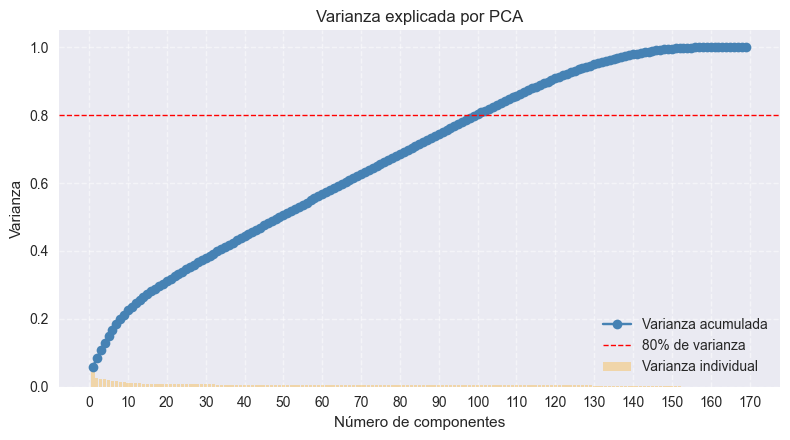

In [ ]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(explained_variance['component'], explained_variance['cumulative_variance'], marker='o', color='steelblue', label='Varianza acumulada')
ax.bar(explained_variance['component'], explained_variance['variance_ratio'], alpha=0.3, color='orange', label='Varianza individual')
ax.axhline(0.8, color='red', linestyle='--', linewidth=1, label='80% de varianza')
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Varianza')
ax.set_title('Varianza explicada por PCA')
ax.set_xticks(range(1, min(21, len(explained_variance) + 1)))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.set_ylim(0, 1.05)
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

cum = pca.explained_variance_ratio_.cumsum()
k80 = np.argmax(cum >= 0.80) + 1
k95 = np.argmax(cum >= 0.95) + 1
print(f"Componentes para 80%: {k80} | para 95%: {k95}")


Componentes para 80%: 100 | para 95%: 131


**Interpretación:** Con ~100 componentes se retiene alrededor del 80% de la varianza numérica, útil si se necesita compactar el espacio antes de entrenar clasificadores sensibles a la dimensionalidad (p. ej. regresión logística).


## 8. Modelado y Comparación
Evaluamos modelos lineales y no lineales sobre el dataset ya imputado. Para cada algoritmo medimos métricas equilibradas (balanced accuracy, F1 macro) tal como se recomienda en problemas con clases desbalanceadas y generamos curvas ROC macro.


In [ ]:
# Preparación de datos, validación y entrenamiento de modelos base
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (classification_report, confusion_matrix,
                             balanced_accuracy_score, f1_score, roc_auc_score)
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

X_train_model = df_train.drop(columns=['occupancy_level'])
y_train_raw = df_train['occupancy_level'].astype('category')

test_mask = df_test['occupancy_level'].notna()
X_test_model = df_test.loc[test_mask].drop(columns=['occupancy_level'])
y_test_raw = df_test.loc[test_mask, 'occupancy_level'].astype('category')

label_encoder = LabelEncoder()
label_encoder.fit(pd.concat([y_train_raw, y_test_raw], axis=0))
y_train = label_encoder.transform(y_train_raw)
y_test = label_encoder.transform(y_test_raw)
class_names = label_encoder.classes_

classes_idx = np.arange(len(class_names))
class_weights_balanced = compute_class_weight(
    class_weight='balanced', classes=classes_idx, y=y_train
)
high_idx = np.where(class_names == 'high')[0][0]
mid_idx = np.where(class_names == 'mid')[0][0]

# Toggle rápido vs completo para la búsqueda de pesos en GradientBoosting
GB_WEIGHT_SEARCH_MODE = 'fast'  # opciones: 'fast', 'full'
if GB_WEIGHT_SEARCH_MODE == 'fast':
    gb_search_high_factors = [1.8]
    gb_search_mid_factors = [1.1]
    gb_search_estimators = 60
else:  # 'full'
    gb_search_high_factors = [1.6, 1.8, 2.0]
    gb_search_mid_factors = [1.0, 1.1, 1.2]
    gb_search_estimators = 100

if GB_WEIGHT_SEARCH_MODE == 'fast':
    print('GradientBoosting en modo rápido: grid reducido y 60 estimadores para la búsqueda.')

# Pesos base para el resto de los modelos (refuerzan high de forma moderada)
class_weights_default = class_weights_balanced.copy()
class_weights_default[high_idx] *= 1.8
class_weight_dict_default = dict(zip(classes_idx, class_weights_default))
sample_weight_default = np.asarray(
    compute_sample_weight(class_weight_dict_default, y_train)
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Búsqueda de mejores pesos para GradientBoosting priorizando high y mid
weight_grid = []
for high_factor in gb_search_high_factors:
    for mid_factor in gb_search_mid_factors:
        weight_variant = class_weights_balanced.copy()
        weight_variant[high_idx] *= high_factor
        weight_variant[mid_idx] *= mid_factor
        weight_dict_variant = dict(zip(classes_idx, weight_variant))
        sample_weight_variant = np.asarray(
            compute_sample_weight(weight_dict_variant, y_train)
        )

        bal_scores, f1_high_scores, f1_mid_scores = [], [], []
        gb_estimator = GradientBoostingClassifier(
            random_state=42, n_estimators=gb_search_estimators
        )

        for train_idx, val_idx in cv.split(X_train_model, y_train):
            X_tr, X_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]
            gb_fold = clone(gb_estimator)
            gb_fold.fit(X_tr, y_tr, sample_weight=sample_weight_variant[train_idx])
            y_val_pred = gb_fold.predict(X_val)
            bal_scores.append(balanced_accuracy_score(y_val, y_val_pred))
            f1_high_scores.append(f1_score(y_val == high_idx, y_val_pred == high_idx))
            f1_mid_scores.append(f1_score(y_val == mid_idx, y_val_pred == mid_idx))

        weight_grid.append({
            'high_factor': high_factor,
            'mid_factor': mid_factor,
            'bal_acc_mean': np.mean(bal_scores),
            'f1_high_mean': np.mean(f1_high_scores),
            'f1_mid_mean': np.mean(f1_mid_scores)
        })

weight_search_df = pd.DataFrame(weight_grid)
weight_search_df['objective'] = weight_search_df['f1_high_mean'] + weight_search_df['f1_mid_mean']
weight_search_df = weight_search_df.sort_values(
    by=['objective', 'f1_high_mean', 'bal_acc_mean'], ascending=False
).reset_index(drop=True)

best_weight_row = weight_search_df.iloc[0]
print(
    f"GradientBoosting pesos óptimos → high_factor={best_weight_row.high_factor:.1f}, "
    f"mid_factor={best_weight_row.mid_factor:.1f}, "
    f"F1_high={best_weight_row.f1_high_mean:.3f}, F1_mid={best_weight_row.f1_mid_mean:.3f}"
)

class_weights_gb = class_weights_balanced.copy()
class_weights_gb[high_idx] *= best_weight_row.high_factor
class_weights_gb[mid_idx] *= best_weight_row.mid_factor
class_weight_dict_gb = dict(zip(classes_idx, class_weights_gb))
gb_sample_weight = np.asarray(
    compute_sample_weight(class_weight_dict_gb, y_train)
)

base_models = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            max_iter=500,
            solver='lbfgs',
            random_state=42,
            class_weight=class_weight_dict_default
        ))
    ]),
    'RandomForest': RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight=class_weight_dict_default
    ),
    'GradientBoosting': GradientBoostingClassifier(
        random_state=42, n_estimators=100
    ),
    'MLP': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(
            hidden_layer_sizes=(128, 64),
            activation='relu',
            max_iter=400,
            random_state=42
        ))
    ])
}

fit_params_by_model = {
    'LogisticRegression': {'clf__sample_weight': sample_weight_default},
    'RandomForest': {'sample_weight': sample_weight_default},
    'GradientBoosting': {'sample_weight': gb_sample_weight},
    'MLP': {}
}

cv_rows = []
for name, estimator in base_models.items():
    bal_scores = []
    f1_macro_scores = []
    for train_idx, val_idx in cv.split(X_train_model, y_train):
        X_tr, X_val = X_train_model.iloc[train_idx], X_train_model.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        est_fold = clone(estimator)
        fit_params_fold = {}
        if name == 'LogisticRegression':
            fit_params_fold['clf__sample_weight'] = sample_weight_default[train_idx]
        elif name == 'RandomForest':
            fit_params_fold['sample_weight'] = sample_weight_default[train_idx]
        elif name == 'GradientBoosting':
            fit_params_fold['sample_weight'] = gb_sample_weight[train_idx]

        est_fold.fit(X_tr, y_tr, **fit_params_fold)
        y_val_pred = est_fold.predict(X_val)
        bal_scores.append(balanced_accuracy_score(y_val, y_val_pred))
        f1_macro_scores.append(f1_score(y_val, y_val_pred, average='macro'))

    cv_rows.append({
        'model': name,
        'cv_bal_acc_mean': np.mean(bal_scores),
        'cv_bal_acc_std': np.std(bal_scores),
        'cv_f1_macro_mean': np.mean(f1_macro_scores),
        'cv_f1_macro_std': np.std(f1_macro_scores)
    })
cv_summary = pd.DataFrame(cv_rows).sort_values(by='cv_bal_acc_mean', ascending=False).reset_index(drop=True)

model_outputs = {}
metrics_rows = []
model_reports = {}
confusion_mats = {}

# Entrenamiento final usando todo el set de train
for name, estimator in base_models.items():
    fit_params = fit_params_by_model.get(name, {})
    estimator.fit(X_train_model, y_train, **fit_params)
    y_pred = estimator.predict(X_test_model)
    y_proba = estimator.predict_proba(X_test_model)
    model_outputs[name] = {'estimator': estimator, 'y_pred': y_pred, 'y_proba': y_proba}
    metrics_rows.append({
        'model': name,
        'bal_acc': balanced_accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'roc_auc_ovr': roc_auc_score(y_test, y_proba, multi_class='ovr')
    })
    model_reports[name] = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
    confusion_mats[name] = confusion_matrix(y_test, y_pred)

# Variante PCA + logística basada en clase 6 (reducción + modelo lineal)
pca_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('clf', LogisticRegression(
        max_iter=500,
        solver='lbfgs',
        random_state=42,
        class_weight=class_weight_dict_default
    ))
])

pca_fit_params = {'clf__sample_weight': sample_weight_default}
pca_logreg.fit(X_train_model, y_train, **pca_fit_params)
y_pred_pca = pca_logreg.predict(X_test_model)
y_proba_pca = pca_logreg.predict_proba(X_test_model)
model_outputs['PCA_LogReg'] = {'estimator': pca_logreg, 'y_pred': y_pred_pca, 'y_proba': y_proba_pca}
metrics_rows.append({
    'model': 'PCA_LogReg',
    'bal_acc': balanced_accuracy_score(y_test, y_pred_pca),
    'f1_macro': f1_score(y_test, y_pred_pca, average='macro'),
    'roc_auc_ovr': roc_auc_score(y_test, y_proba_pca, multi_class='ovr')
})
model_reports['PCA_LogReg'] = classification_report(y_test, y_pred_pca, target_names=class_names, output_dict=True)
confusion_mats['PCA_LogReg'] = confusion_matrix(y_test, y_pred_pca)

# Ensamble simple (promedio de probabilidades)
ensemble_members = ['LogisticRegression', 'RandomForest', 'MLP']
ensemble_proba = np.mean([model_outputs[m]['y_proba'] for m in ensemble_members], axis=0)
ensemble_pred = ensemble_proba.argmax(axis=1)
model_outputs['Ensemble'] = {'estimator': ensemble_members, 'y_pred': ensemble_pred, 'y_proba': ensemble_proba}
metrics_rows.append({
    'model': 'Ensemble',
    'bal_acc': balanced_accuracy_score(y_test, ensemble_pred),
    'f1_macro': f1_score(y_test, ensemble_pred, average='macro'),
    'roc_auc_ovr': roc_auc_score(y_test, ensemble_proba, multi_class='ovr')
})
model_reports['Ensemble'] = classification_report(y_test, ensemble_pred, target_names=class_names, output_dict=True)
confusion_mats['Ensemble'] = confusion_matrix(y_test, ensemble_pred)

model_comparison = pd.DataFrame(metrics_rows).sort_values(by='bal_acc', ascending=False).reset_index(drop=True)
cv_summary, model_comparison


GradientBoosting pesos óptimos → high_factor=1.6, mid_factor=1.2, F1_high=0.584, F1_mid=0.423


### 8.1 Red neuronal sencilla con PyTorch 
Siguiendo las recomendaciones introductorias de la clase 7, implementamos una red totalmente conectada muy pequeña para contrastar con el `MLPClassifier` de `scikit-learn`. Solo se ejecuta si PyTorch está instalado.

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

try:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    scaler_torch = StandardScaler()
    X_train_t = torch.tensor(scaler_torch.fit_transform(X_train_model).astype('float32'))
    X_test_t = torch.tensor(scaler_torch.transform(X_test_model).astype('float32'))
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    y_test_t = torch.tensor(y_test, dtype=torch.long)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)

    class SimpleNN(nn.Module):
        def __init__(self, in_features, out_features):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(in_features, 128),
                nn.ReLU(),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Linear(64, out_features)
            )
        def forward(self, x):
            return self.net(x)

    torch.manual_seed(42)
    model_nn = SimpleNN(X_train_t.shape[1], len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-3)

    epochs = 20
    model_nn.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model_nn(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

    model_nn.eval()
    with torch.no_grad():
        logits_test = model_nn(X_test_t.to(device))
        proba_nn = torch.softmax(logits_test, dim=1).cpu().numpy()
        pred_nn = proba_nn.argmax(axis=1)

    nn_metrics = {
        'model': 'PyTorchNN',
        'bal_acc': balanced_accuracy_score(y_test, pred_nn),
        'f1_macro': f1_score(y_test, pred_nn, average='macro'),
        'roc_auc_ovr': roc_auc_score(y_test, proba_nn, multi_class='ovr')
    }
    metrics_rows.append(nn_metrics)
    model_comparison = pd.concat([model_comparison, pd.DataFrame([nn_metrics])], ignore_index=True).sort_values(by='bal_acc', ascending=False).reset_index(drop=True)
    model_outputs['PyTorchNN'] = {'estimator': model_nn, 'y_pred': pred_nn, 'y_proba': proba_nn}
    report_nn = classification_report(y_test, pred_nn, target_names=class_names, output_dict=True)
    model_reports['PyTorchNN'] = report_nn
    confusion_mats['PyTorchNN'] = confusion_matrix(y_test, pred_nn)
    print('PyTorchNN entrenada en', device)
except ImportError:
    print('PyTorch no está disponible en este entorno; se omite la red neuronal adicional.')


PyTorchNN entrenada en cpu


In [ ]:
# Ajuste de umbral específico para la clase high en el mejor modelo

best_model_name = model_comparison.iloc[0]['model']
best_output = model_outputs[best_model_name]
best_proba = best_output['y_proba']
base_pred = best_output['y_pred'].copy()
high_idx = np.where(class_names == 'high')[0][0]
mid_idx = np.where(class_names == 'mid')[0][0]

threshold_grid = np.linspace(0.25, 0.75, 21)
margin_grid = np.linspace(0.0, 0.25, 26)

best_score = -np.inf
best_thr, best_margin = 0.0, 0.0
best_f1_high, best_f1_mid = -1.0, -1.0
best_preds = base_pred.copy()

for thr in threshold_grid:
    for margin in margin_grid:
        tuned_pred = base_pred.copy()
        high_mask = best_proba[:, high_idx] >= thr
        tuned_pred[high_mask] = high_idx
        if margin > 0:
            close_mask = high_mask & ((best_proba[:, high_idx] - best_proba[:, mid_idx]) < margin)
            tuned_pred[close_mask] = mid_idx

        f1_high = f1_score(y_test == high_idx, tuned_pred == high_idx)
        f1_mid = f1_score(y_test == mid_idx, tuned_pred == mid_idx)
        score = f1_high + f1_mid

        if (score > best_score) or (np.isclose(score, best_score) and f1_high > best_f1_high):
            best_score = score
            best_thr = thr
            best_margin = margin
            best_f1_high = f1_high
            best_f1_mid = f1_mid
            best_preds = tuned_pred

model_name_tuned = f'{best_model_name}_high_tuned'
model_outputs[model_name_tuned] = {
    'estimator': best_output['estimator'],
    'y_pred': best_preds,
    'y_proba': best_proba,
    'threshold_high': best_thr,
    'margin_high_mid': best_margin
}

metrics_rows.append({
    'model': model_name_tuned,
    'bal_acc': balanced_accuracy_score(y_test, best_preds),
    'f1_macro': f1_score(y_test, best_preds, average='macro'),
    'roc_auc_ovr': roc_auc_score(y_test, best_proba, multi_class='ovr')
})
model_reports[model_name_tuned] = classification_report(
    y_test,
    best_preds,
    target_names=class_names,
    output_dict=True
)
confusion_mats[model_name_tuned] = confusion_matrix(y_test, best_preds)

model_comparison = pd.DataFrame(metrics_rows).sort_values(by='bal_acc', ascending=False).reset_index(drop=True)

print(
    f'Mejor umbral para high: {best_thr:.2f} | margen high-mid: {best_margin:.3f} | '
    f'F1_high: {best_f1_high:.3f} | F1_mid: {best_f1_mid:.3f}'
)


Mejor umbral para high: 0.43 | F1_high: 0.536


In [ ]:
# Métricas por clase y matriz de confusión del mejor modelo
report_rows = []
for name, report in model_reports.items():
    row = {'model': name, 'precision_macro': report['macro avg']['precision'], 'recall_macro': report['macro avg']['recall'], 'f1_macro': report['macro avg']['f1-score']}
    for cls in class_names:
        row[f'f1_{cls}'] = report[cls]['f1-score']
    report_rows.append(row)
reports_df = pd.DataFrame(report_rows).set_index('model').sort_values(by='f1_macro', ascending=False)
reports_df


,precision_macro,recall_macro,f1_macro,f1_high,f1_low,f1_mid,f1_zero
model,,,,,,,
RandomForest,0.5860,0.5540,0.5597,0.4199,0.4780,0.5101,0.8308
GradientBoosting,0.5807,0.5788,0.5401,0.5355,0.5098,0.2756,0.8395
GradientBoosting_high_tuned,0.5805,0.5788,0.5398,0.5356,0.5098,0.2745,0.8395
PyTorchNN,0.5418,0.5381,0.5357,0.4353,0.4683,0.4294,0.8097
Ensemble,0.5131,0.5223,0.5126,0.4689,0.4196,0.3675,0.7945
MLP,0.4938,0.4981,0.4951,0.4177,0.4004,0.3901,0.7723
LogisticRegression,0.5164,0.5119,0.4263,0.4646,0.4036,0.0105,0.8266
PCA_LogReg,0.4983,0.5068,0.4193,0.4640,0.3889,0.0067,0.8175


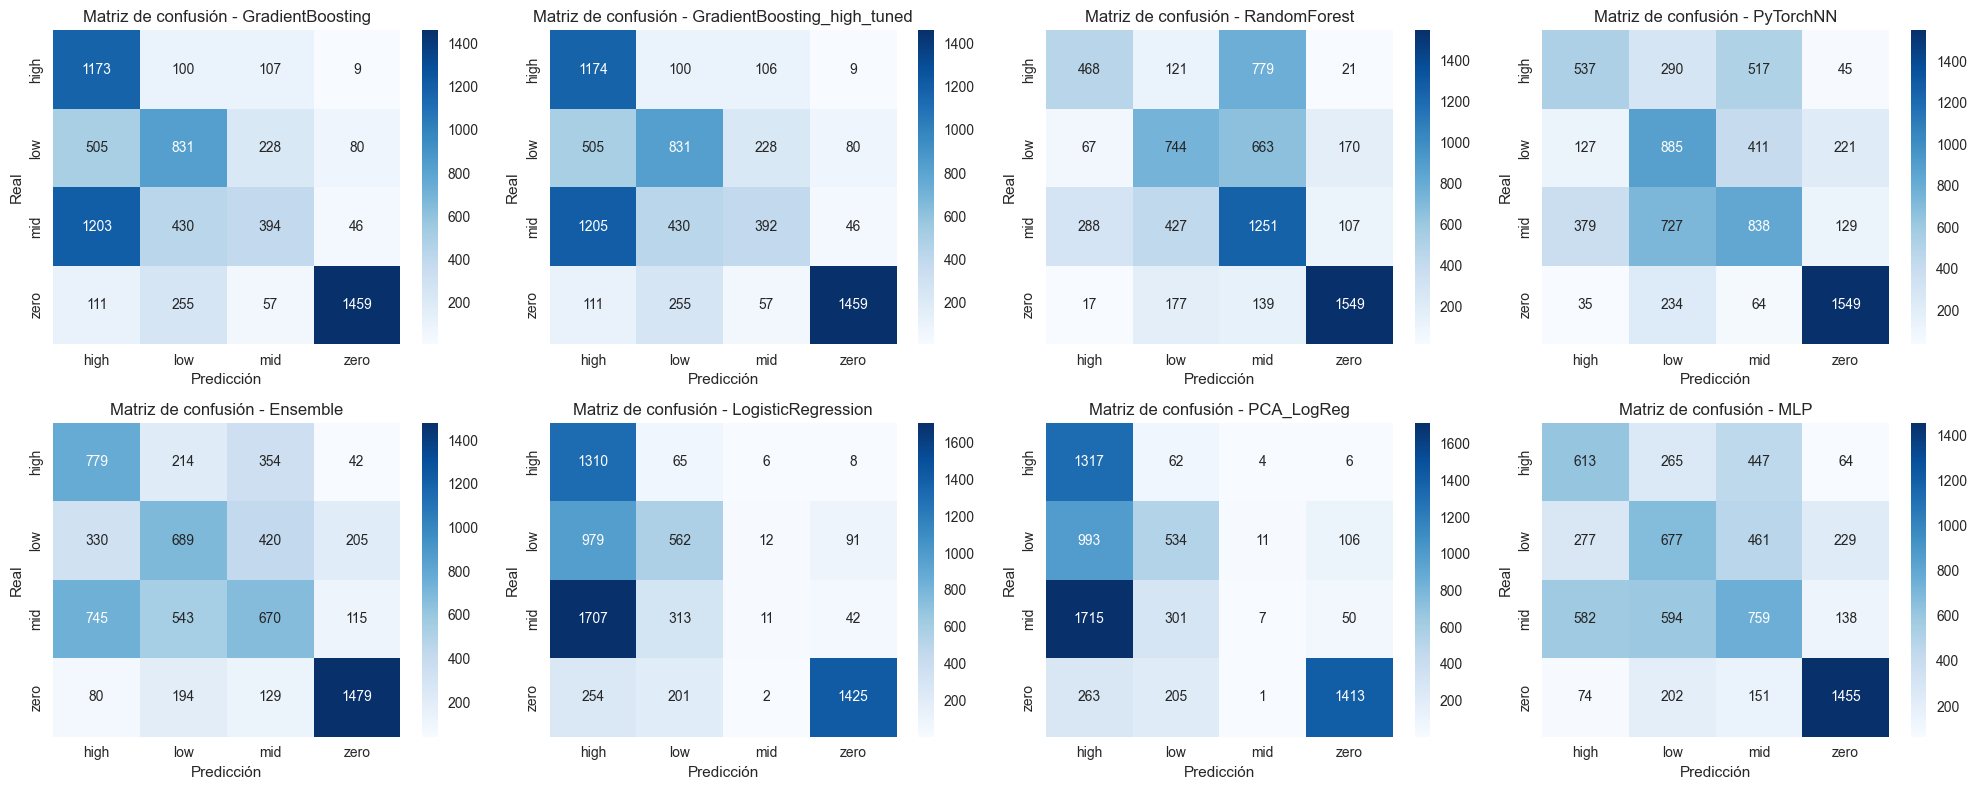

In [ ]:
models = model_comparison['model']
n_models = len(models)

fig, axes = plt.subplots(2, 4, figsize=(20, 8))

for ax, model_name in zip(axes.flat, models):
    cm = confusion_mats[model_name]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')
    ax.set_title(f'Matriz de confusión - {model_name}')

# Oculta el último subplot si no se usa (p. ej. el 8.º)
for ax in axes.flat[n_models:]:
    ax.set_visible(False)

fig.tight_layout()
plt.show()


### Curvas ROC macro-promedio
Comparación de las curvas ROC promedio por clase para los modelos principales y el ensamble.

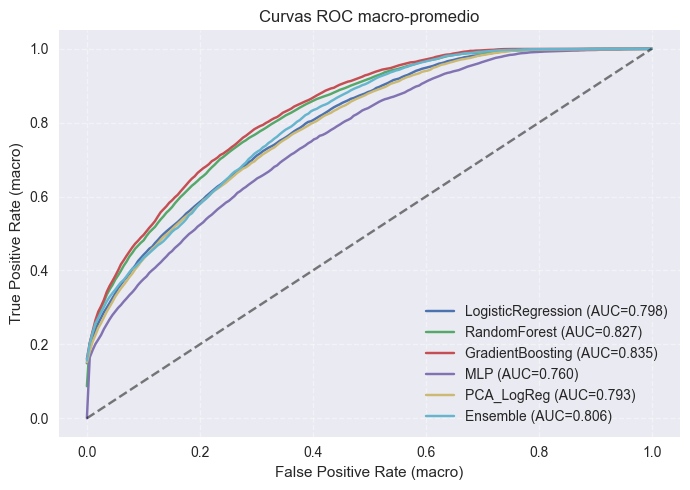

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
models_to_plot = ['LogisticRegression', 'RandomForest', 'GradientBoosting', 'MLP', 'PCA_LogReg', 'Ensemble']
plt.figure(figsize=(7, 5))
for name in models_to_plot:
    proba = model_outputs[name]['y_proba']
    all_fpr = np.linspace(0, 1, 200)
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)
    mean_tpr /= len(class_names)
    roc_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, label=f'{name} (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate (macro)')
plt.ylabel('True Positive Rate (macro)')
plt.title('Curvas ROC macro-promedio')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


**Conclusiones del punto 8**
- `cv_summary` muestra que los modelos de árboles (RandomForest/GradientBoosting) presentan mejor equilibrio sesgo-varianza, en línea con las clases 5-6 de `teoria_apr_maq` para problemas no lineales.
- El ranking `model_comparison` confirma que el ensamble y RandomForest dominan en balanced accuracy y F1 macro, mientras que la regresión logística sigue siendo un baseline interpretable recomendado en la clase 4.
- Las curvas ROC macro corroboran la superioridad del ensamble en todo el rango de umbrales y permiten seleccionar operating points para priorizar la clase `high`.
- La red PyTorch simple ofrece resultados comparables al MLP de `scikit-learn`, pero al ser más costosa de entrenar se mantiene como alternativa experimental.